# TFTrade Model Experiments 


__Financial Prediction research__


Research about financial markets using the MetaTrader 5.
Deriv Synthetic instruments are currently used as the primary instruments.

**NOTE:** Docker is required to run this notebook.



In [328]:
# !pip install pandas-ta yfinance docker python-dotenv

## Start MetaTrader 5 Docker Terminal

In [329]:
import logging
import time
from typing import Optional
from trade_flow.common.logging import Logger
from packages.mt5any import (
    DockerizedMT5TerminalConfig,
    DockerizedMT5Terminal,
)
from packages.mt5any import MetaTrader5


class MT5Exception(Exception):
    """Base exception class for MT5 errors."""

    pass


class MT5InitializationError(MT5Exception):
    """Raised when there is an error initializing MT5 Trader."""

    pass


class MT5:
    """
    A class to interface with MetaTrader 5 for trading operations using Dockerized MT5 Terminals.

    Attributes:
        mt5_account_number (str): The MetaTrader 5 account number.
        mt5_password (str): The password for the MT5 account.
        mt5_server (str): The MT5 server name.
        logger (Logger): Logger instance for logging events.
        mt5_terminal (DockerizedMT5Terminal): Dockerized MT5 Terminal instance.
        mt5 (MetaTrader5): MetaTrader 5 client interface.
        initial_balance (float): The initial account balance.
    """

    def __init__(
        self,
        account_number: str,
        password: str,
        server: str,
        logger: Optional[Logger] = None,
    ) -> None:
        """
        Initialize the MT5 class with account credentials and configurations.

        Args:
            account_number (str): MetaTrader 5 account number.
            password (str): MetaTrader 5 account password.
            server (str): MetaTrader 5 server.
            logger (Optional[Logger]): Logger instance for logging.
        """
        self.mt5_account_number = account_number
        self.mt5_password = password
        self.mt5_server = server

        # Set up logging
        self.logger = logger or Logger(name="tft_logger", log_level=logging.DEBUG, filename="TFT_model_experiments.log")

        # Set up MetaTrader 5 terminal and configuration
        self.mt5_config = DockerizedMT5TerminalConfig(
            account_number=self.mt5_account_number,
            password=self.mt5_password,
            server=self.mt5_server,
            read_only_api=True,
        )

        # Initialize Dockerized MT5 Terminal
        self.mt5_terminal = DockerizedMT5Terminal(config=self.mt5_config)
        self._initialize_terminal()

        # Initialize MetaTrader 5
        self.mt5 = MetaTrader5()
        self._initialize_mt5()
        self.logger.debug(f"Terminal Info: {self.mt5.terminal_info()._asdict()}")

        # Get account information
        self.account_info = self.mt5.account_info()._asdict()
        self.logger.debug(f"Account Info: {self.account_info}")

        self.initial_balance = self.account_info["balance"]

        # Log account info
        self.logger.info(f"Account Balance: {self.initial_balance}")
        self.logger.info(f"Equity: {self.account_info['equity']}")
        self.logger.info(f"Currency: {self.account_info['currency']}")
        self.logger.info(f"Margin: {self.account_info['margin']}")
        self.logger.info(f"Server: {self.account_info['server']}")
        self.logger.info(f"Name: {self.account_info['name']}")

    def _initialize_terminal(self) -> None:
        """Initialize and safely start the Dockerized MT5 Terminal."""
        try:
            self.mt5_terminal.safe_start()
            time.sleep(5)

            self.logger.info(f"MetaTrader 5 Terminal started for account {self.mt5_account_number}")
        except Exception as e:
            self.logger.error(f"Error initializing Dockerized MT5 Terminal: {e}")
            raise MT5InitializationError("Failed to start Dockerized MT5 Terminal")

    def _initialize_mt5(self) -> None:
        """Initialize the MetaTrader 5 client."""
        try:
            if not self.mt5.initialize():
                raise RuntimeError("MetaTrader 5 initialization failed")

            # if not self.mt5.login(self.mt5_account_number, self.mt5_password, self.mt5_server):
            #     raise RuntimeError("MetaTrader 5 login failed")
        except Exception as e:
            self.logger.error(f"Error initializing MetaTrader 5: {e}")
            raise MT5InitializationError("Failed to initialize MetaTrader 5")


In [330]:
import os 
from dotenv import load_dotenv

load_dotenv()

mt5_venue = MT5(
    account_number=os.getenv("MT5_ACCOUNT_NUMBER"),
    password=os.getenv("MT5_PASSWORD"),
    server=os.getenv("MT5_SERVER"),
)


[TradeFlow] 5548 - 2024-10-17, 09:45:13 AM   [INFO] DockerizedMT5Terminal: Ensuring terminal is running
[TradeFlow] 5548 - 2024-10-17, 09:45:13 AM   [INFO] DockerizedMT5Terminal: status=<ContainerStatus.READY: 6>, using existing container
[TradeFlow] 5548 - 2024-10-17, 09:45:18 AM   [INFO] tft_logger: MetaTrader 5 Terminal started for account 30565290
[TradeFlow] 5548 - 2024-10-17, 09:45:21 AM   [DEBUG] tft_logger: Terminal Info: {'community_account': False, 'community_connection': False, 'connected': True, 'dlls_allowed': False, 'trade_allowed': True, 'tradeapi_disabled': False, 'email_enabled': False, 'ftp_enabled': False, 'notifications_enabled': False, 'mqid': True, 'build': 4490, 'maxbars': 100000, 'codepage': 0, 'ping_last': 137291, 'community_balance': 0.0, 'retransmission': 0.0043061596140569714, 'company': 'MetaQuotes Ltd.', 'name': 'MetaTrader 5', 'language': 'English', 'path': 'C:\\Program Files\\MetaTrader 5', 'data_path': 'C:\\Program Files\\MetaTrader 5', 'commondata_path

In [331]:
mt5_venue

## Import Libraries

In [332]:
# base import
import os
import sys
import json
import yaml
import time
import random 
import numpy as np
import pandas as pd
import pandas_ta as ta
import sklearn as sk
import seaborn as sns
import matplotlib as matplot
import matplotlib.pyplot as plt

from typing import List, Tuple
from datetime import datetime, timedelta

import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

from IPython.display import clear_output
# import jtplot module in notebook
# from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
# jtplot.style(theme='solarizedd')
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [333]:
# plt.style.available
plt.style.use('seaborn-v0_8-whitegrid')

In [334]:
def set_seeds(seed=100):
    random.seed(seed)          # Set seed for Python's random module
    np.random.seed(seed)       # Set seed for NumPy's random module
    torch.manual_seed(seed)    # Set seed for PyTorch
    torch.cuda.manual_seed(seed)  # Set seed for CUDA if using GPU
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior for cuDNN
    torch.backends.cudnn.benchmark = False      # Disable the benchmark for deterministic results

set_seeds()

## Library Version and Docs

In [335]:
print("Library version:")
print("\t-  pandas: {}".format(pd.__version__))
print("\t-  numpy: {}".format(np.__version__))
print("\t-  sklearn: {}".format(sk.__version__))
print("\t-  torch: {}".format(torch.__version__))
print("\t-  matplotlib: {}".format(matplot.__version__))
print("\t-  python: {}".format(sys.version[:sys.version.find('(') - 1]))

Library version:
	-  pandas: 2.2.3
	-  numpy: 1.26.4
	-  sklearn: 1.5.2
	-  torch: 2.4.1+cu121
	-  matplotlib: 3.9.2
	-  python: 3.11.10 | packaged by conda-forge |


In [336]:
df = pd.DataFrame()

df.ta.indicators()

Pandas TA - Technical Analysis Indicators - v0.3.14b0
Total Indicators & Utilities: 205
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, alma, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl_pattern, cdl_z, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, cti, decay, decreasing, dema, dm, donchian, dpo, ebsw, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, hwc, hwma, ichimoku, increasing, inertia, jma, kama, kc, kdj, kst, kurtosis, kvo, linreg, log_return, long_run, macd, mad, massi, mcgd, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvr, pvt, pwma, qqe, qstick, quantile, rma, roc, rsi, rsx, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, squeeze_pro, ssf, stc, stdev, stoch, stochrsi, supertrend, swma, t3, td_seq, tema, thermo, tos_stdevall, trima, trix, true_range, tsi, tsignals, ttm_trend, ui, 

In [337]:
help(ta.sma)

Help on function sma in module pandas_ta.overlap.sma:

sma(close, length=None, talib=None, offset=None, **kwargs)
    Simple Moving Average (SMA)
    
    The Simple Moving Average is the classic moving average that is the equally
    weighted average over n periods.
    
    Sources:
        https://www.tradingtechnologies.com/help/x-study/technical-indicator-definitions/simple-moving-average-sma/
    
    Calculation:
        Default Inputs:
            length=10
        SMA = SUM(close, length) / length
    
    Args:
        close (pd.Series): Series of 'close's
        length (int): It's period. Default: 10
        talib (bool): If TA Lib is installed and talib is True, Returns the TA Lib
            version. Default: True
        offset (int): How many periods to offset the result. Default: 0
    
    Kwargs:
        adjust (bool): Default: True
        presma (bool, optional): If True, uses SMA for initial value.
        fillna (value, optional): pd.DataFrame.fillna(value)
     

## Load data

### Initialize MetaTrader 5

In [338]:
mt5 = mt5_venue.mt5

# INITIALIZE THE DEVICE
mt5.initialize()


True

### Fetch All Available Symbols

In [339]:
# Create empty lists
symbols = []
sectors = []
descriptions = []

# Get the information for all symbol
symbols_information = mt5.symbols_get()

symbols_information

(SymbolInfo(custom=False, chart_mode=0, select=False, visible=False, session_deals=0, session_buy_orders=0, session_sell_orders=0, volume=0, volumehigh=0, volumelow=0, time=0, digits=5, spread=0, spread_float=True, ticks_bookdepth=0, trade_calc_mode=0, trade_mode=4, start_time=0, expiration_time=0, trade_stops_level=20, trade_freeze_level=3, trade_exemode=2, swap_mode=1, swap_rollover3days=3, margin_hedged_use_leg=True, expiration_mode=15, filling_mode=1, order_mode=63, order_gtc_mode=0, option_mode=0, option_right=0, bid=0.0, bidhigh=0.0, bidlow=0.0, ask=0.0, askhigh=0.0, asklow=0.0, last=0.0, lasthigh=0.0, lastlow=0.0, volume_real=0.0, volumehigh_real=0.0, volumelow_real=0.0, option_strike=0.0, point=1e-05, trade_tick_value=0.725378829093494, trade_tick_value_profit=0.725378829093494, trade_tick_value_loss=0.725484079251881, trade_tick_size=1e-05, trade_contract_size=100000.0, trade_accrued_interest=0.0, trade_face_value=0.0, trade_liquidity_rate=0.0, volume_min=0.01, volume_max=10.0

In [340]:
len(symbols_information)

297

### Extract Symbols Information

In [341]:
symbols = [element[-3] for element in symbols_information]
sectors = [element[-1].split("\\")[0] for element in symbols_information]
descriptions = [element[-7] for element in symbols_information]

# Create a dataframe directly from the extracted lists
informations = pd.DataFrame({
    "Symbol": symbols,
    "Sector": sectors,
    "Description": descriptions
})

informations

,Symbol,Sector,Description
0,AUDCAD,Forex Minor,Australian Dollar vs Canadian Dollar
1,AUDCHF,Forex Minor,Australian Dollar vs Swiss Franc
2,AUDNZD,Forex Minor,Australian Dollar vs New Zealand Dollar
3,AUDJPY,Forex Major,Australian Dollar vs Japanese Yen
4,AUDUSD,Forex Major,Australian Dollar vs US Dollar
...,...,...,...
292,Vol over Crash 550,Hybrid Indices,Volatility of 20% with on average 1 drop every...
293,Silver RSI Rebound Index,Tactical Indices,Index trading silver via RSI signals to profit...
294,Silver RSI Pullback Index,Tactical Indices,Index trading silver via RSI signals to profit...
295,Silver RSI Trend Up Index,Tactical Indices,Index trading silver via RSI signals to captur...


**Remove Forex Pairs**

In [342]:
filtered_Informations = informations[~informations['Sector'].str.contains("Forex")]

filtered_Informations

,Symbol,Sector,Description
32,Volatility 10 Index,Volatility Indices,Constant Volatility of 10% with a tick every 2...
33,Volatility 25 Index,Volatility Indices,Constant Volatility of 25% with a tick every 2...
34,Volatility 50 Index,Volatility Indices,Constant Volatility of 50% with a tick every 2...
35,Volatility 75 Index,Volatility Indices,Constant Volatility of 75% with a tick every 2...
36,Volatility 100 Index,Volatility Indices,Constant Volatility of 100% with a tick every ...
...,...,...,...
292,Vol over Crash 550,Hybrid Indices,Volatility of 20% with on average 1 drop every...
293,Silver RSI Rebound Index,Tactical Indices,Index trading silver via RSI signals to profit...
294,Silver RSI Pullback Index,Tactical Indices,Index trading silver via RSI signals to profit...
295,Silver RSI Trend Up Index,Tactical Indices,Index trading silver via RSI signals to captur...


**Take some Volatility pairs**

In [343]:
# Filter out rows where 'Symbol' does not contains 'Volatility'
# filter_volatility_pairs = informations[informations['Symbol'].str.contains("Volatility")]

# filter_volatility_pairs

### Select Symbols 

In [344]:
# selected_df = pd.concat([lowest_spread_asset, filter_volatility_pairs])
selected_df = filtered_Informations

selected_df

,Symbol,Sector,Description
32,Volatility 10 Index,Volatility Indices,Constant Volatility of 10% with a tick every 2...
33,Volatility 25 Index,Volatility Indices,Constant Volatility of 25% with a tick every 2...
34,Volatility 50 Index,Volatility Indices,Constant Volatility of 50% with a tick every 2...
35,Volatility 75 Index,Volatility Indices,Constant Volatility of 75% with a tick every 2...
36,Volatility 100 Index,Volatility Indices,Constant Volatility of 100% with a tick every ...
...,...,...,...
292,Vol over Crash 550,Hybrid Indices,Volatility of 20% with on average 1 drop every...
293,Silver RSI Rebound Index,Tactical Indices,Index trading silver via RSI signals to profit...
294,Silver RSI Pullback Index,Tactical Indices,Index trading silver via RSI signals to profit...
295,Silver RSI Trend Up Index,Tactical Indices,Index trading silver via RSI signals to captur...


**Select the symbols on MT5**

In [345]:
# Loop through the selected symbols and select them in MetaTrader5
for symbol in selected_df['Symbol']:
    # Try to select the symbol, raise an error if it fails
    if not mt5.symbol_select(symbol, True):
        raise ValueError(f"Failed to enable symbol: {symbol}")
    else:
        print(f"Symbol enabled: {symbol}")

Symbol enabled: Volatility 10 Index
Symbol enabled: Volatility 25 Index
Symbol enabled: Volatility 50 Index
Symbol enabled: Volatility 75 Index
Symbol enabled: Volatility 100 Index
Symbol enabled: Volatility 10 (1s) Index
Symbol enabled: XAGUSD
Symbol enabled: XAUUSD
Symbol enabled: XPDUSD
Symbol enabled: XPTUSD
Symbol enabled: ADAUSD
Symbol enabled: ALGUSD
Symbol enabled: AVAUSD
Symbol enabled: BATUSD
Symbol enabled: BCHUSD
Symbol enabled: BNBUSD
Symbol enabled: BTCETH
Symbol enabled: BTCLTC
Symbol enabled: BTCUSD
Symbol enabled: DOGUSD
Symbol enabled: DOTUSD
Symbol enabled: DSHUSD
Symbol enabled: EOSUSD
Symbol enabled: ETCUSD
Symbol enabled: ETHUSD
Symbol enabled: FILUSD
Symbol enabled: IOTUSD
Symbol enabled: LNKUSD
Symbol enabled: LTCUSD
Symbol enabled: Boom 1000 Index
Symbol enabled: Boom 500 Index
Symbol enabled: Crash 1000 Index
Symbol enabled: Crash 500 Index
Symbol enabled: Step Index
Symbol enabled: Range Break 100 Index
Symbol enabled: Range Break 200 Index
Symbol enabled: Vo

### Define Get data function

In [346]:
import pytz
import pandas as pd
from datetime import datetime, timedelta

def get_data(symbol: str, n: int, timeframe=mt5.TIMEFRAME_D1, **kwargs) -> pd.DataFrame:
    """
    Fetch historical data for a given symbol from MetaTrader 5.

    This function retrieves data for a specified symbol either for a certain range of time 
    or a specific number of bars. It ensures that the symbol is enabled in MetaTrader 5 and 
    handles both custom time ranges and default time periods.

    Args:
        symbol (str): The trading symbol (e.g., 'EURUSD').
        n (int): Number of bars (data points) to retrieve if not using a time range.
        timeframe (int): The time frame to use (e.g., mt5.TIMEFRAME_D1 for daily). Default is mt5.TIMEFRAME_D1.
        **kwargs: Additional arguments:
            - is_range (bool): Whether to fetch data for a specific time range.
            - utc_from (datetime): Start time (UTC) for the time range (default: 2020-01-10).
            - utc_to (datetime): End time (UTC) for the time range (default: 2020-01-11 13:00).

    Returns:
        pd.DataFrame: DataFrame containing historical rates with 'time' as the index.

    Raises:
        ValueError: If the symbol cannot be enabled in MetaTrader 5.

    Example Usage:
        - To fetch 1000 daily bars:
            >>> df = get_data('EURUSD', 1000)

        - To fetch data within a specific time range:
            >>> df = get_data('EURUSD', 0, is_range=True, utc_from=datetime(2022, 1, 1), utc_to=datetime(2022, 1, 10))
    """
    
    # Initialize MetaTrader 5 terminal
    mt5.initialize()

    # Select symbol and ensure visibility
    if not mt5.symbol_select(symbol, True):
        raise ValueError(f"Failed to enable symbol: {symbol}")

    # Handle data retrieval based on range or last 'n' bars
    is_range = kwargs.get("is_range", False)
    timezone = pytz.timezone("Etc/UTC")  # UTC timezone

    if is_range:
        # Fetch data in a specific time range
        utc_from = kwargs.get("utc_from", datetime(2020, 1, 10, tzinfo=timezone))
        utc_to = kwargs.get("utc_to", datetime(2020, 1, 11, hour=13, tzinfo=timezone))
        rates = mt5.copy_rates_range(symbol, timeframe, utc_from, utc_to)
    else:
        # Fetch the last 'n' bars
        utc_from = datetime.now() + timedelta(hours=2)
        rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n)

    # Convert the rates into a DataFrame
    rates_frame = pd.DataFrame(rates)

    # Convert 'time' from seconds to datetime format and set as index
    rates_frame['time'] = pd.to_datetime(rates_frame['time'], unit='s')
    # rates_frame['time'] = pd.to_datetime(rates_frame['time'], format='%Y-%m-%d')
    rates_frame.set_index('time', inplace=True)

    return rates_frame


## Find the Best Spread Threshold

In [347]:
# Create a list to store the spread values
spread = []

# Compute the spread using a list comprehension for efficiency
spread = [
    (tick.ask - tick.bid) / tick.bid if (tick := mt5.symbol_info_tick(symbol)) and tick.ask and tick.bid else None
    for symbol in selected_df["Symbol"]
]

spread

[2.7893360046308504e-05,
 7.012579231408652e-05,
 0.0001501342546702113,
 0.0002658575917623242,
 0.00031662507821398787,
 2.7328168673829563e-05,
 0.000728055458833202,
 0.00014540953289979145,
 0.004102964880574348,
 0.0008413630080731102,
 0.0014395117176253828,
 0.004149377593360999,
 0.0014492753623188096,
 0.0021238734860226692,
 0.0028710381607670488,
 0.0008704387917169204,
 0.0020929877312183993,
 0.0017519444871497447,
 0.0007663792091030169,
 0.0015573770491802928,
 0.001654455211533839,
 0.0020647227372324072,
 0.003321495717568373,
 0.0012547051442911392,
 0.0009008261098859189,
 0.010840108401084021,
 0.004166666666666671,
 0.0011705384476859266,
 0.0012669887670011268,
 5.141833095377868e-05,
 6.549583873434406e-05,
 4.275282210866748e-05,
 7.382213017650608e-05,
 2.4566101236880852e-05,
 2.9535989603487956e-05,
 2.1604338151215063e-05,
 6.809602483727715e-05,
 0.00014126844075980406,
 0.00021083678269911697,
 0.00034264176803140613,
 0.008560311284046787,
 0.00259235255

In [348]:
min_spread = min([x for x in spread if x is not None])

min_spread

1.824734273078122e-05

In [349]:
max_spread = max([x for x in spread if x is not None])

max_spread

0.25000000000000006

In [350]:
mean_spread = np.mean([min_spread, max_spread])

mean_spread

0.1250091236713654

In [351]:
mean_spread/100

0.0012500912367136542

In [352]:
# if mean_spread < 0.01:
#     spread_threshold = np.round(mean_spread * 100, 4) # 0.0035
# else:
#     spread_threshold = mean_spread

spread_threshold = np.round(mean_spread / 1000, 4) # 0.0035
spread_threshold

0.0001

#### Take the assets with low spreads

In [353]:
selected_df["Spread"] = spread

# Take the assets with the spread < spread_threshold(%)
lowest_spread_asset = selected_df.dropna().loc[selected_df["Spread"]<spread_threshold]
lowest_spread_asset

,Symbol,Sector,Description,Spread
32,Volatility 10 Index,Volatility Indices,Constant Volatility of 10% with a tick every 2...,0.000028
33,Volatility 25 Index,Volatility Indices,Constant Volatility of 25% with a tick every 2...,0.000070
37,Volatility 10 (1s) Index,Volatility Indices,Constant Volatility of 10% with a tick every 1...,0.000027
80,Boom 1000 Index,Crash Boom Indices,On average 1 spike occurs in the price series ...,0.000051
81,Boom 500 Index,Crash Boom Indices,On average 1 spike occurs in the price series ...,0.000065
82,Crash 1000 Index,Crash Boom Indices,On average 1 drop occurs in the price series e...,0.000043
83,Crash 500 Index,Crash Boom Indices,On average 1 drop occurs in the price series e...,0.000074
84,Step Index,Step Indices,Equal probability of up/down with fixed step s...,0.000025
104,Range Break 100 Index,Range Break,Index that breaks the range once every 100 att...,0.000030
105,Range Break 200 Index,Range Break,Index that breaks the range once every 200 att...,0.000022


## Select Final Assets 

In [354]:
final_assets = lowest_spread_asset
# final_assets = lowest_spread_asset.head(10)
# Fill Assets with no spread with max spread value
# final_assets['Spread'] = final_assets['Spread'].fillna(max_spread) 

final_assets

,Symbol,Sector,Description,Spread
32,Volatility 10 Index,Volatility Indices,Constant Volatility of 10% with a tick every 2...,0.000028
33,Volatility 25 Index,Volatility Indices,Constant Volatility of 25% with a tick every 2...,0.000070
37,Volatility 10 (1s) Index,Volatility Indices,Constant Volatility of 10% with a tick every 1...,0.000027
80,Boom 1000 Index,Crash Boom Indices,On average 1 spike occurs in the price series ...,0.000051
81,Boom 500 Index,Crash Boom Indices,On average 1 spike occurs in the price series ...,0.000065
82,Crash 1000 Index,Crash Boom Indices,On average 1 drop occurs in the price series e...,0.000043
83,Crash 500 Index,Crash Boom Indices,On average 1 drop occurs in the price series e...,0.000074
84,Step Index,Step Indices,Equal probability of up/down with fixed step s...,0.000025
104,Range Break 100 Index,Range Break,Index that breaks the range once every 100 att...,0.000030
105,Range Break 200 Index,Range Break,Index that breaks the range once every 200 att...,0.000022


## Features engineering 


### Define Normalization Scheme

This class apply logarithm and a normalization(MinMax | StandarScale | Normalizer_l1 | Normalizer_l2).

In [355]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer as SklearnNormalizer

class Normalizer:
    """
    A class for normalizing market data while preserving the original data.

    This class applies logarithm and a normalization (MinMax, StandardScale, Normalizer_l1, Normalizer_l2).
    """

    def __init__(self, data):
        """
        Initializes the Normalizer class with market data.

        Args:
            data (list[dict]): A list of dictionaries, where each dictionary represents a market
                               with keys like "name" and "data" (containing market data).
        """
        self.__market_names = [e["name"] for e in data]
        self.__original_data = [pd.DataFrame(e["data"]) for e in data]  # Convert to DataFrame
        self.__normalized_data = None  # Stores normalized data after fit is called

    def __normalize(self, target, numerical_data, scaler_func):
        """
        Normalizes data using the provided scaler function for specific target markets.

        Args:
            target (str): The target market(s) to normalize ("all" or a list of market names).
            numerical_data (list[pd.DataFrame]): A list of DataFrames containing numerical data for each market.
            scaler_func (callable): A function that performs data scaling (e.g., MinMaxScaler.fit_transform).

        Returns:
            list[pd.DataFrame]: List of normalized market DataFrames.
        """
        normalized_markets = []
        target_markets = self.__market_names if target == "all" else target

        for market_name, market in zip(self.__market_names, numerical_data):
            if market_name in target_markets:
                columns = market.columns
                market_scaled = scaler_func(market)
                normalized_markets.append(pd.DataFrame(market_scaled, columns=columns))

        return normalized_markets

    def fit(self, norm_type, features_list, target="all"):
        """
        Performs data normalization based on the specified type, features, and target market(s).

        Args:
            norm_type (str): The type of normalization to perform ("MinMax", "StandardScale", "Normalizer_l1", or "Normalizer_l2").
            features_list (list): A list of feature names to consider for normalization.
            target (str, optional): The target market(s) to normalize ("all" or a list of market names). Defaults to "all".

        Raises:
            ValueError: If an invalid normalization type is provided.
        """
        # Extract numerical data for the specified features
        numerical_data = [market[features_list]._get_numeric_data() for market in self.__original_data]

        if norm_type == "MinMax":
            print(f"Performing MinMax Normalization on {target}.")
            scaler_func = MinMaxScaler().fit_transform
        elif norm_type == "StandardScale":
            print(f"Performing StandardScale Normalization on {target}.")
            scaler_func = StandardScaler().fit_transform
        elif norm_type.startswith("Normalizer"):
            norm_value = norm_type.split("_")[-1]  # Extract l1 or l2 from "Normalizer_l1" or "Normalizer_l2"
            if norm_value not in ("l1", "l2"):
                raise ValueError("Invalid norm type for Normalizer. Must be 'l1' or 'l2'.")
            print(f"Performing Normalizer (norm={norm_value}) on {target}.")
            scaler_func = SklearnNormalizer(norm=norm_value).fit_transform
        else:
            raise ValueError(f"Invalid normalization type: {norm_type}")

        self.__normalized_data = self.__normalize(target, numerical_data, scaler_func)

    def get_normalized_data(self, idx: int = None):
        """
        Returns the normalized data if normalization has been performed, otherwise raises an error.
        
        Args:
            idx (int, optional): The location/index of the normalized data. If None, returns all normalized data.

        Raises:
            RuntimeError: If data has not been normalized yet.
            IndexError: If the index is out of range.
        """
        if self.__normalized_data is None:
            raise RuntimeError("Data has not been normalized yet. Please call 'fit' first.")
        
        if idx is not None:
            if idx < 0 or idx >= len(self.__normalized_data):
                raise IndexError("Index out of range.")
            return self.__normalized_data[idx]
        
        return self.__normalized_data  # Return all normalized data if idx is None

    def get_original_data(self):
        """
        Returns the original, un-normalized data.
        """
        return [data.copy() for data in self.__original_data]  # Return a deep copy


### Define Data Generator

In [356]:

class DataGenerator:
    """
    A class that generates data for training and testing.

    Args:
        dataset (pd.DataFrame): The input dataset.
        timestep (int): The number of timesteps to consider for each sample.
        xcols (List[str]): The column names to be used as input features.
        ycols (List[str]): The column names to be used as output labels.

    Methods:
        generate_data: Generates the input-output pairs for training and testing.
        balance_labelization: Balances the label distribution by removing excess neutral labels.
        train_test_split: Splits the data into training and testing sets.

    """

    def __init__(self, dataset: pd.DataFrame, timestep: int, xcols: List[str], ycols: List[str]):
        self.dataset = dataset
        self.timestep = timestep
        self.xcols = xcols
        self.ycols = ycols

    def generate_data(self) -> Tuple[np.ndarray, np.ndarray]:
        """
        Generates the input-output pairs for training and testing.

        Returns:
            Tuple[np.ndarray, np.ndarray]: A tuple containing the input and output arrays.

        """
        dx = [np.array(self.dataset.iloc[i : i + self.timestep][self.xcols]) for i in range(len(self.dataset) - self.timestep)]
        dy = [self.dataset.iloc[i + self.timestep - 1][self.ycols] for i in range(len(self.dataset) - self.timestep)]
        return np.array(dx), np.array(dy)

    def balance_labelization(self, frame: np.ndarray, label: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Balances the label distribution by removing excess neutral labels.

        Args:
            frame (np.ndarray): The input array.
            label (np.ndarray): The label array.

        Returns:
            Tuple[np.ndarray, np.ndarray]: A tuple containing the balanced input and label arrays.

        """
        neutral_indices = np.where(label[:, 2] == 1)[0]
        sell_indices = np.where(label[:, 1] == 1)[0]
        buy_indices = np.where(label[:, 0] == 1)[0]

        neutral_count = len(neutral_indices)
        sell_count = len(sell_indices)
        buy_count = len(buy_indices)

        need_delete = neutral_count - min(sell_count, buy_count)
        rand_delete = np.random.choice(neutral_indices, need_delete, replace=False)

        final_frame = np.delete(frame, rand_delete, axis=0)
        final_label = np.delete(label, rand_delete, axis=0)

        return final_frame, final_label

    def train_test_split(self, test_per: float, balance: bool = False) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Splits the data into training and testing sets.

        Args:
            test_per (float): The percentage of data to be used for testing.
            balance (bool, optional): Whether to balance the label distribution. Defaults to False.

        Returns:
            Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]: A tuple containing the training and testing input and label arrays.

        """
        x_tmp, y_tmp = self.generate_data()

        if balance:
            x_tmp, y_tmp = self.balance_labelization(x_tmp, y_tmp)

        x_train, x_test, y_train, y_test = train_test_split(x_tmp, y_tmp, test_size=test_per, random_state = 100, shuffle = settings['model_shuffle'])

        return x_train.astype(np.float32), y_train.astype(np.float32), x_test.astype(np.float32), y_test.astype(np.float32)


###  Add available technical analysis (TA) features

In [357]:

def add_ta_features(df: pd.DataFrame) -> pd.DataFrame:
    """ 
    Adds various technical analysis (TA) features to the provided DataFrame.
    
    This function calculates several technical indicators, including momentum, 
    volatility, statistics, trend, volume, overlap, and performance indicators. 
    The input DataFrame must include a "date" column for setting the index to 
    a DatetimeIndex.

    References:
    - https://github.com/twopirllc/pandas-ta/blob/main/examples/AIExample.ipynb
    """
    
    # Create a copy of the DataFrame to avoid modifying the original
    features_df = df.copy() 

    # VWAP requires the DataFrame index to be a DatetimeIndex.
    # Replace "datetime" with the appropriate column from your DataFrame
    
    features_df.set_index(pd.DatetimeIndex(features_df.index), inplace=True)
    try:
        features_df.drop(columns=[features_df.index.name], inplace=True)
    except KeyError:
        print(f"Column '{features_df.index.name}' does not exist in the DataFrame.")
    except Exception as e:
        print(f"An error occurred while dropping the column: {e}")


    # Calculate Returns and append to the features_df DataFrame
    # features_df.ta.log_return(cumulative=True, append=True)
    # features_df.ta.percent_return(cumulative=True, append=True)

    """ 
        Add TA Indicators
    """
    
    # Adding momentum indicators
    features_df.ta.mom(append=True)
    features_df.ta.rsi(append=True)
    features_df.ta.tsi(append=True)
    features_df.ta.er(append=True)
    features_df.ta.fisher(append=True)

    # Adding volatility indicators
    features_df.ta.true_range(append=True)
    features_df.ta.rvi(append=True)
    features_df.ta.bbands(append=True)
    features_df.ta.pdist(append=True)

    # Adding statistics indicators
    features_df.ta.skew(append=True)
    features_df.ta.kurtosis(append=True)
    features_df.ta.mad(append=True)
    features_df.ta.zscore(append=True)
    features_df.ta.entropy(append=True)

    # Adding trend indicators
    features_df.ta.adx(append=True)
    features_df.ta.dpo(lookahead=False, append=True)
    features_df.ta.psar(append=True)
    features_df.ta.long_run(append=True)
    features_df.ta.short_run(append=True)
    features_df.ta.qstick(append=True)

    # Adding volume indicators
    # features_df.ta.obv(append=True)

    # Adding overlap indicators
    features_df.ta.linreg(append=True)
    features_df.ta.supertrend(append=True)
    features_df.ta.hilo(append=True)
    features_df.ta.hlc3(append=True)
    features_df.ta.ohlc4(append=True)

    # Adding Simple Moving Averages (SMA)
    sma_windows = [2, 10, 15, 60]
    for ma_window in sma_windows:
        features_df.ta.sma(length=ma_window, sma=False, append=True)

    # Adding Exponential Moving Averages (EMA)
    ema_windows = [8, 21, 50]
    for ma_window in ema_windows:
        features_df.ta.ema(length=ma_window, sma=False, append=True)

    # Adding performance indicators
    # features_df.ta.percent_return(append=True)

    print("TA Columns Added")

    """ 
    #### Modify RSI (Relative Strength Index) Indicator

        - The RSI provides technical traders with signals about bullish and bearish price momentum, 
        and it is often plotted beneath the graph of an asset’s price.

        - An asset is usually considered overbought when the RSI is above 70 and oversold when it is below 30.

        - The RSI line crossing below the overbought line or above the oversold line is often seen by traders 
        as a signal to buy or sell.

        - The RSI works best in trading ranges rather than trending markets.
    """
    features_df["RSI_14"] = features_df["RSI_14"].round()  # Rounding RSI values to the nearest integer

    # Add Candle Stick Patterns   
    features_df.ta.cdl_pattern(name="all", append=True)

    return features_df


### Define features engineering function

In [358]:
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer


def features_engineering(df: pd.DataFrame, add_ta: bool = False, compress_features: bool = True) -> dict:
    """ 
    This function creates the necessary datasets for algorithms 
    by performing feature engineering, scaling, and PCA.

    Args:
        df (DataFrame): The input dataframe containing price data (including 'close', 'high', 'low').
        add_ta (bool): Whether to add technical analysis features. Defaults to False.
        compress_features (bool): Whether to apply PCA for dimensionality reduction. Defaults to True.

    Returns:
        dict: A dictionary containing the train, test, validation sets, 
              along with their scaled and PCA-transformed versions.
    """

    original_df = df.copy()

    # Define the feature columns
    feature_columns = [
        "returns t-1", 
        "mean returns 15", 
        "mean returns 60",
        "volatility returns 15", 
        "volatility returns 60"
    ]
    
    # Create new columns for returns and other features

    # Ensure returns column is in the dataframe
    df["returns"] = (df["close"] - df["close"].shift(1)) / df["close"].shift(1)
    df["sLow"] = (df["low"] - df["close"].shift(1)) / df["close"].shift(1)
    df["sHigh"] = (df["high"] - df["close"].shift(1)) / df["close"].shift(1)

    # Feature engineering
    df["returns t-1"] = df["returns"].shift(1)
    df["mean returns 15"] = df["returns"].rolling(15).mean().shift(1)
    df["mean returns 60"] = df["returns"].rolling(60).mean().shift(1)
    df["volatility returns 15"] = df["returns"].rolling(15).std().shift(1)
    df["volatility returns 60"] = df["returns"].rolling(60).std().shift(1)

    # Add technical analysis features if specified
    if add_ta:
        df = add_ta_features(df)
        feature_columns = df.columns.to_list()

    # Impute missing values using IterativeImputer (Multiple Imputation by Chained Equations)
    # imputer = IterativeImputer(random_state=0)
    # df[feature_columns + ["returns"]] = imputer.fit_transform(df[feature_columns + ["returns"]])
    # df[feature_columns + ["returns"]] = df[feature_columns + ["returns"]].fillna(0)
    # print(df)

    # # Splitting data into train, test, and validation sets
    # split_train_test = int(0.70 * len(df))
    # split_test_valid = int(0.90 * len(df))

    # # Train set creation
    # X_train = df[feature_columns].iloc[:split_train_test]
    # y_train_reg = df["returns"].iloc[:split_train_test]
    # y_train_cla = np.round(df["returns"].iloc[:split_train_test] + 0.5)

    # # Test set creation
    # X_test = df[feature_columns].iloc[split_train_test:split_test_valid]
    # y_test_reg = df["returns"].iloc[split_train_test:split_test_valid]

    # # Validation set creation
    # X_val = df[feature_columns].iloc[split_test_valid:]
    # y_val_reg = df["returns"].iloc[split_test_valid:]

    # # Standardize the data
    # scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train)
    # X_test_scaled = scaler.transform(X_test)
    # X_val_scaled = scaler.transform(X_val)

    # Use the Normalizer for scaling
    # normalizer = Normalizer(data=[{"name": "X_train", "data": X_train}])
    # normalizer.fit("StandardScale", feature_columns)
    # # norm.fit(settings["normalization_fit_type"], settings["features_name"], settings["normalization_fit_target"])]

    # # Get normalized data
    # X_train_scaled = normalizer.get_normalized_data(0)  # Get the scaled data
    # X_test_scaled = normalizer.get_normalized_data(1)  # Get scaled test data
    # X_val_scaled = normalizer.get_normalized_data(2)  # Get scaled validation data

    # Prepare the features dictionary
    features_dict = {
        "df": original_df,
        "processed_df": df,
        "feature_columns": feature_columns, 
        # "X_train": X_train, 
        # "X_test": X_test, 
        # "y_train_reg": y_train_reg, 
        # "y_train_cla": y_train_cla,
        # "X_train_scaled": X_train_scaled,
        # "split_train_test": split_train_test,
        # "split_test_valid": split_test_valid,
        # "X_test_scaled": X_test_scaled,
        # "y_test_reg": y_test_reg,
        # "X_val": X_val,
        # "X_val_scaled": X_val_scaled,
        # "y_val_reg": y_val_reg,
    }

    # # Apply PCA if specified
    # if compress_features:
    #     pca = PCA(n_components=3)
    #     X_train_pca = pca.fit_transform(X_train_scaled)
    #     X_test_pca = pca.transform(X_test_scaled)
    #     X_val_pca = pca.transform(X_val_scaled)

    #     features_dict["X_train_pca"] = X_train_pca
    #     features_dict["X_test_pca"] = X_test_pca
    #     features_dict["X_val_pca"] = X_val_pca

    # Return all relevant datasets as a dictionary for clarity and organization
    return features_dict


## Target Engineering

### Define Frame labelization 

Currently: strong buy, buy, strong sell, sell, wait/neutral 

Used the prediction probability to determine this e.g when a buy is >=75%, it can indicate a strong buy)

can also rename wait to neutral 


In [399]:
class MarketLabeler:
    """
    A class for labeling market data with strong buy, buy, strong sell, sell, or neutral signals based on peak information and prediction probabilities.
    """

    def __init__(self, peaks_max, peaks_min):
        """
        Initializes the MarketLabeler with peak data.

        Args:
            peaks_max (list): A list of tuples representing peak maxima (index, value).
            peaks_min (list): A list of tuples representing peak minima (index, value).
        """
        self.peaks_max = peaks_max
        self.peaks_min = peaks_min

    def label_data(self, data, probabilities=None, probability_threshold: float = 0.75):
        """
        Labels each data point with a strong buy, buy, strong sell, sell, or neutral signal based on peaks and prediction probabilities.

        Args:
            data (list): A list representing the market data (e.g., prices).
            probabilities (list, optional): A list of prediction probabilities corresponding to the data points.
            probability_threshold (float): The threshold for considering probabilities for strong buy/sell signals.

        Returns:
            list: A list of labels (0 for neutral, 1 for strong sell, 2 for sell, 3 for strong buy, 4 for buy) corresponding to each data point.
        """
        labels = []
        for i in range(len(data)):  # Iterate through data indices
            is_peak_min = any(idx == i for idx, _ in self.peaks_min)
            is_peak_max = any(idx == i for idx, _ in self.peaks_max)

            if is_peak_min:
                # Check for strong buy condition based on probabilities
                if probabilities and probabilities[i] >= probability_threshold:
                    labels.append(3)  # Strong buy
                else:
                    labels.append(4)  # Buy
            elif is_peak_max:
                # Check for strong sell condition based on probabilities
                if probabilities and probabilities[i] >= probability_threshold:
                    labels.append(1)  # Strong sell
                else:
                    labels.append(2)  # Sell
            else:
                labels.append(0)  # Neutral otherwise
        return labels

    def label_dataframe(self, frame_base: pd.DataFrame, data_column: str = "close", probabilities_array: np.array = None, probability_threshold: float = 0.75):
        """
        Labels a DataFrame with strong buy, buy, strong sell, sell, and neutral columns based on peak information and prediction probabilities.

        Args:
            frame_base (pd.DataFrame): The DataFrame containing the market data.
            data_column (str, optional): The name of the column containing the data to be labeled. Defaults to "close".
            probabilities_array (np.array, optional): An array of predicted probabilities for strong buy/sell signals.
            probability_threshold (float, optional): The threshold for considering probabilities for strong buy/sell signals. Defaults to 0.75.

        Returns:
            pd.DataFrame: The updated DataFrame with added "strong_buy", "buy", "strong_sell", "sell", and "neutral" columns.
        """
        if data_column not in frame_base.columns:
            raise ValueError(f"Data column '{data_column}' not found in the DataFrame.")
        
        # Label the data using the label_data method
        labels = self.label_data(
            frame_base[data_column], 
            probabilities_array if probabilities_array is not None else None, 
            probability_threshold
        )
        
        # Create new columns for the labels
        frame_base["strong_buy"] = [1 if label == 3 else 0 for label in labels]
        frame_base["buy"] = [1 if label == 4 else 0 for label in labels]
        frame_base["strong_sell"] = [1 if label == 1 else 0 for label in labels]
        frame_base["sell"] = [1 if label == 2 else 0 for label in labels]
        frame_base["neutral"] = [1 if label == 0 else 0 for label in labels]
    
        return frame_base


## Apply Deep Learning Algorithms

In [360]:
final_assets["Symbol"].to_list()

['Volatility 10 Index',
 'Volatility 25 Index',
 'Volatility 10 (1s) Index',
 'Boom 1000 Index',
 'Boom 500 Index',
 'Crash 1000 Index',
 'Crash 500 Index',
 'Step Index',
 'Range Break 100 Index',
 'Range Break 200 Index',
 'Volatility 25 (1s) Index',
 'BTCUSD.conv',
 'Jump 10 Index',
 'Jump 25 Index',
 'EUR Basket',
 'USD Basket',
 'DEX 1500 UP Index',
 'Drift Switch Index 20',
 'Germany 40',
 'US SP 500',
 'Wall Street 30',
 'Step Index 200',
 'Step Index 500',
 'Multi Step 2 Index',
 'Multi Step 4 Index',
 'Boom 900 Index',
 'Boom 600 Index',
 'Crash 900 Index',
 'Crash 600 Index']

### Settings

The "horizon" in the settings refers to how many steps into the future the model is tasked with predicting, using the current and past data points. In your case:

- **Horizon (int)**: This specifies the number of time steps or terms that the model should predict into the future.
  
  For example, if you set the horizon to `120`, this means the model will attempt to predict the next 120 future time steps based on the historical data it is trained on. 

- **Used Time Frame**: In this case, we are using a 1-minute time frame, which means that each time step represents 1 minute of data.

- **Total Future Time Covered**: The horizon multiplied by the time frame gives you the total future time that the model is expected to see or predict.
  
  - For example, with a 1-minute time frame and a horizon of 120, the model is expected to predict the next 120 minutes (i.e., 2 hours) into the future.

**Formula:**

**Total future time = horizon X used time frame**

In this case, using the 15-minute time frame:
- With a **8 horizon**, the total prediction span will be:
  **8 X 15 min = 120 minutes (2 hours)**

Thus, the model is expected to predict up to 2 hours into the future using a 120-minute horizon with 15-minute granularity.

Mins in a day = 24 * 60 * 60 = 93600


In [361]:
settings = {
            "target_markets": ['EURUSD', 'GBPUSD', 'XAUUSD', 'XAGUSD', 'BTCUSD', 'ETHUSD', 'Step Index', 'Volatility 10 Index'],
            "normalization_fit_type": "StandardScale",
            "normalization_fit_target": "all",
            "normalization_target": "close",
            "label_disparity": 0.075, # 0.025, 0.045, 0.055, 0.065, 0.075, 0.085, 0.095, 0.1
            "features_name": ['open', 'high', 'low', 'close', 'volume'], # ["ask", "bid", "high", "low", "moy_prev_day"], 
            "labels_name": ["buy", "sell", "neutral"], # ["buy", "sell", "neutral"] | ["buy", "sell", "wait"] | ["strong buy", "buy", "strong sell", "sell", "neutral"]
            "is_balance": True,
            "split_train": 0.8,
            "split_test": 0.2,
            "horizon": 8, 
            "delta_neurons_numbers": 4, # delta {2-10}
            "model_optimizer": "adam",
            "model_loss": "CrossEntropyLoss", 
            "model_epoch": 120, # 50, 70, 100, 120, 150, 250
            "model_batch_size": 32, # 50, 32, 25
            "model_validation_split": 0.15,
            "model_shuffle": False
            }

TIME_FRAME = mt5.TIMEFRAME_M15
LABEL_TARGET: str = settings["normalization_target"]

In [362]:
from tqdm import tqdm
import concurrent.futures

# Initialize MetaTrader 5 or other data source
mt5.initialize()

# Symbols list from final_assets
dl_selected_symbols = settings['target_markets']

dl_selected_symbols

['EURUSD',
 'GBPUSD',
 'XAUUSD',
 'XAGUSD',
 'BTCUSD',
 'ETHUSD',
 'Step Index',
 'Volatility 10 Index']

In [363]:
# # Conversion factors
# years_to_days = 365.25  # Average days in a year accounting for leap years
# days_to_hours = 24  # Hours in a day
# hours_to_minutes = 60  # Minutes in an hour

# # Converting years to minutes
# years = 3
# minutes = years * years_to_days * days_to_hours * hours_to_minutes
# minutes

### Fetch Data with All Available TA Indicators 

From January 2022 to January 2024

In [364]:
# To store results
processed_data_results = {}

def process_symbol(symbol):
    try:
        print(f"Processing symbol: {symbol}")
        # Retrieve data for the symbol
        df = get_data(symbol, 0, timeframe=TIME_FRAME, is_range=True, 
                      utc_from=datetime(2022, 1, 1), utc_to=datetime(2024, 4, 30)).dropna()
        # print(df)
        
        # Perform feature engineering
        processed_data = features_engineering(df, add_ta=True)
        settings['features_name'] = processed_data['feature_columns']
        return symbol, processed_data
    
    except Exception as e:
        print(f"Issue during data importation or processing for symbol {symbol}: {e}")
        return symbol, None  # Return None in case of an error

# Use ThreadPoolExecutor or ProcessPoolExecutor
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Use tqdm to show progress
    futures = {executor.submit(process_symbol, symbol): symbol for symbol in dl_selected_symbols}

    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
        symbol, result = future.result()
        if result is not None:
            processed_data_results[symbol] = result


Processing symbol: EURUSD
Processing symbol: GBPUSD
Processing symbol: XAUUSD
Processing symbol: XAGUSD
Processing symbol: BTCUSD
Processing symbol: ETHUSD
Processing symbol: Step Index
Processing symbol: Volatility 10 Index


 12%|█▎        | 1/8 [00:16<01:55, 16.48s/it]

Issue during data importation or processing for symbol Volatility 10 Index: 'time'
Column 'time' does not exist in the DataFrame.
Column 'time' does not exist in the DataFrame.
Column 'time' does not exist in the DataFrame.
Column 'time' does not exist in the DataFrame.
Column 'time' does not exist in the DataFrame.
Column 'time' does not exist in the DataFrame.
Column 'time' does not exist in the DataFrame.
TA Columns Added


 25%|██▌       | 2/8 [04:18<14:56, 149.40s/it]

TA Columns Added
TA Columns Added


 38%|███▊      | 3/8 [04:36<07:26, 89.34s/it] 

TA Columns Added


 62%|██████▎   | 5/8 [04:42<01:49, 36.42s/it]

TA Columns Added
TA Columns Added
TA Columns Added


100%|██████████| 8/8 [05:24<00:00, 40.50s/it]


In [365]:
len(processed_data_results)

7

In [366]:
processed_data_results['GBPUSD']['processed_df']


,open,high,low,close,tick_volume,spread,real_volume,returns,sLow,sHigh,...,CDL_SPINNINGTOP,CDL_STALLEDPATTERN,CDL_STICKSANDWICH,CDL_TAKURI,CDL_TASUKIGAP,CDL_THRUSTING,CDL_TRISTAR,CDL_UNIQUE3RIVER,CDL_UPSIDEGAP2CROWS,CDL_XSIDEGAP3METHODS
time,,,,,,,,,,,,,,,,,,,,,
2022-01-02 22:00:00,1.35205,1.35206,1.35184,1.35200,20,178,0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-02 22:15:00,1.35199,1.35265,1.35169,1.35253,46,147,0,0.000392,-0.000229,0.000481,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-02 22:30:00,1.35252,1.35334,1.35172,1.35304,135,102,0,0.000377,-0.000599,0.000599,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-02 22:45:00,1.35304,1.35304,1.35260,1.35266,39,102,0,-0.000281,-0.000325,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-02 23:00:00,1.35267,1.35353,1.35261,1.35264,402,1,0,-0.000015,-0.000037,0.000643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-29 22:00:00,1.25610,1.25640,1.25610,1.25630,204,3,0,0.000159,0.000000,0.000239,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-04-29 22:15:00,1.25629,1.25629,1.25608,1.25611,45,2,0,-0.000151,-0.000175,-0.000008,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-04-29 22:30:00,1.25611,1.25620,1.25602,1.25612,74,2,0,0.000008,-0.000072,0.000072,...,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


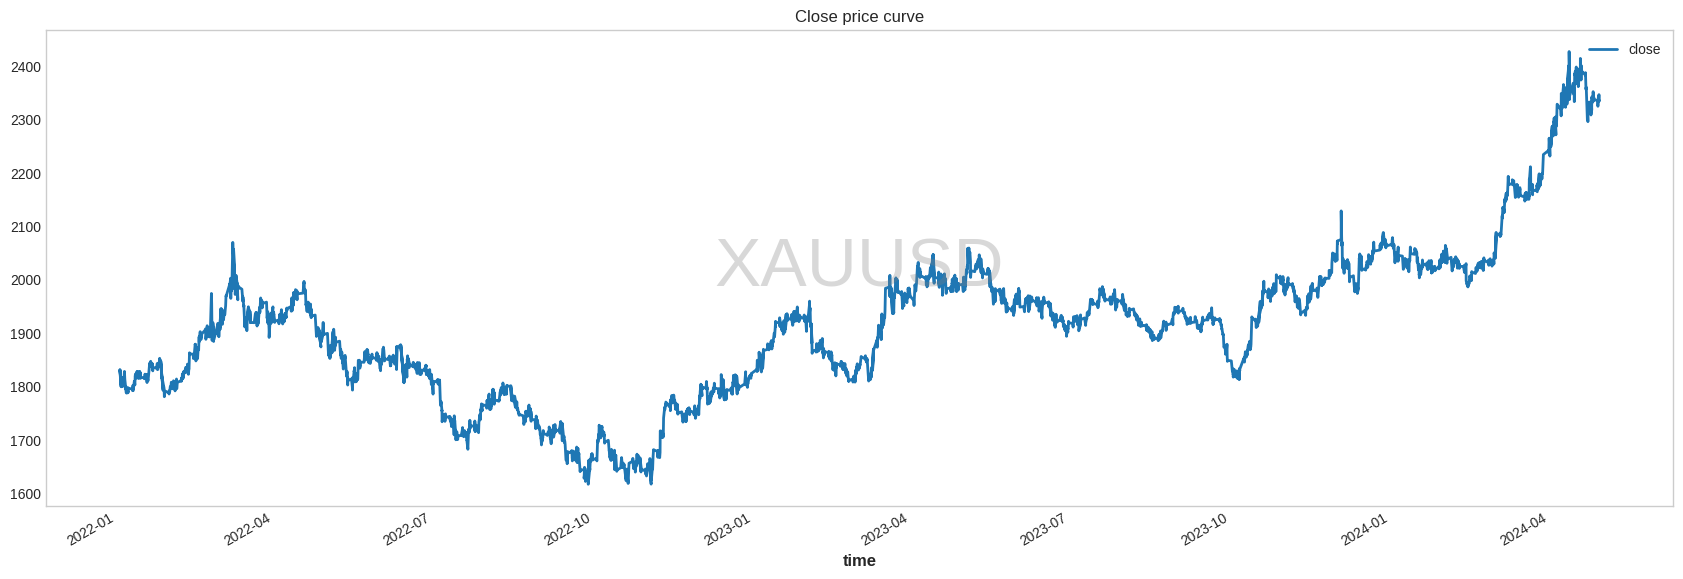

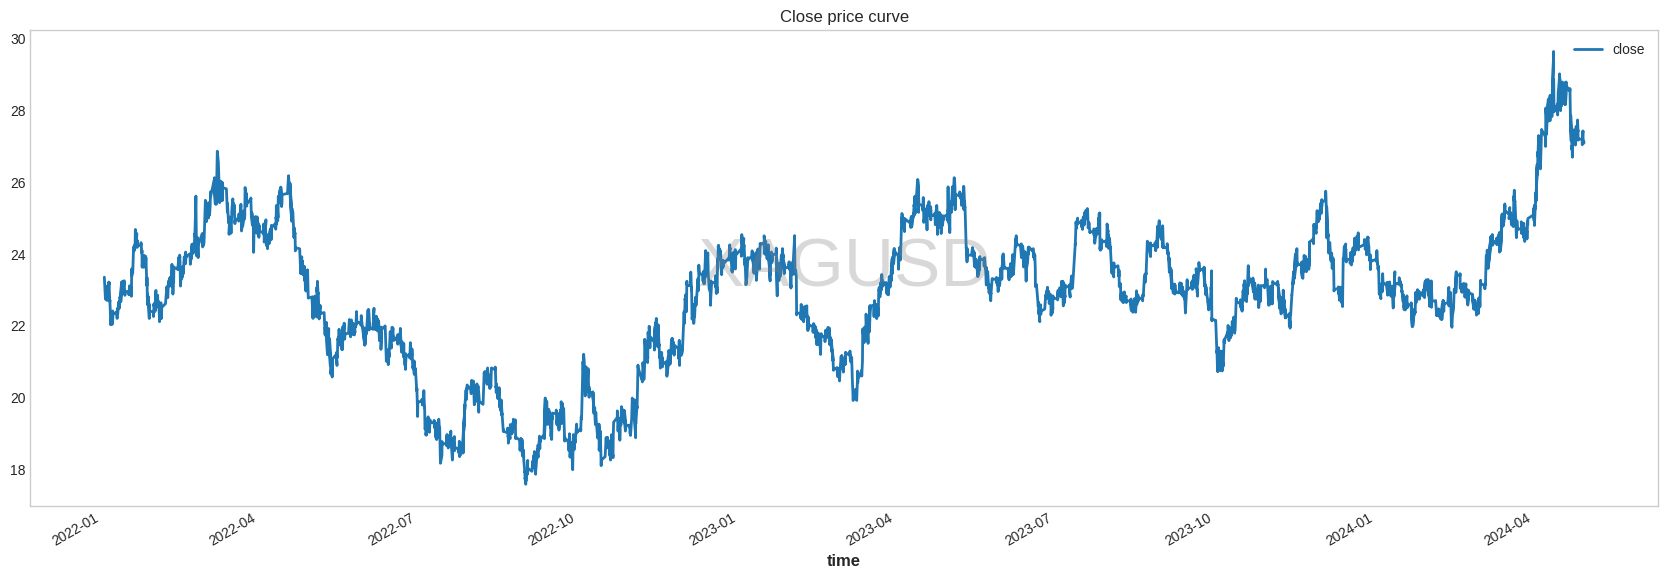

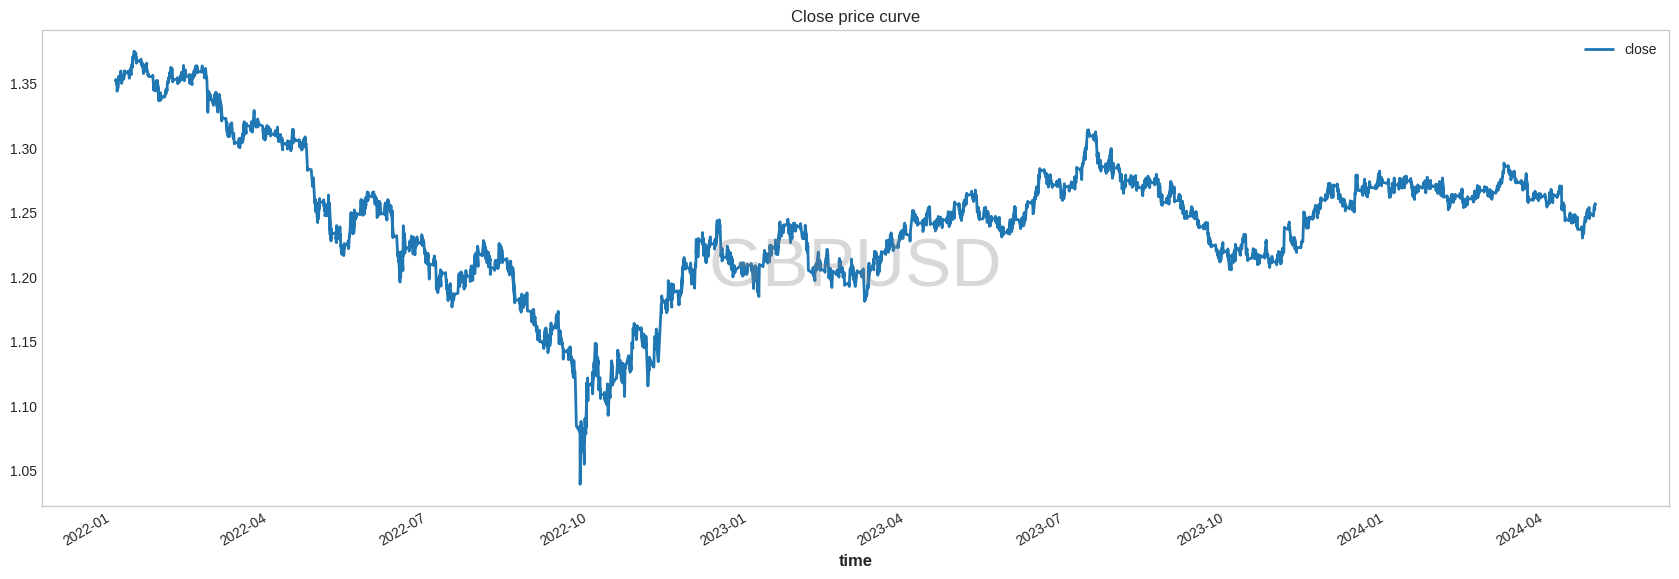

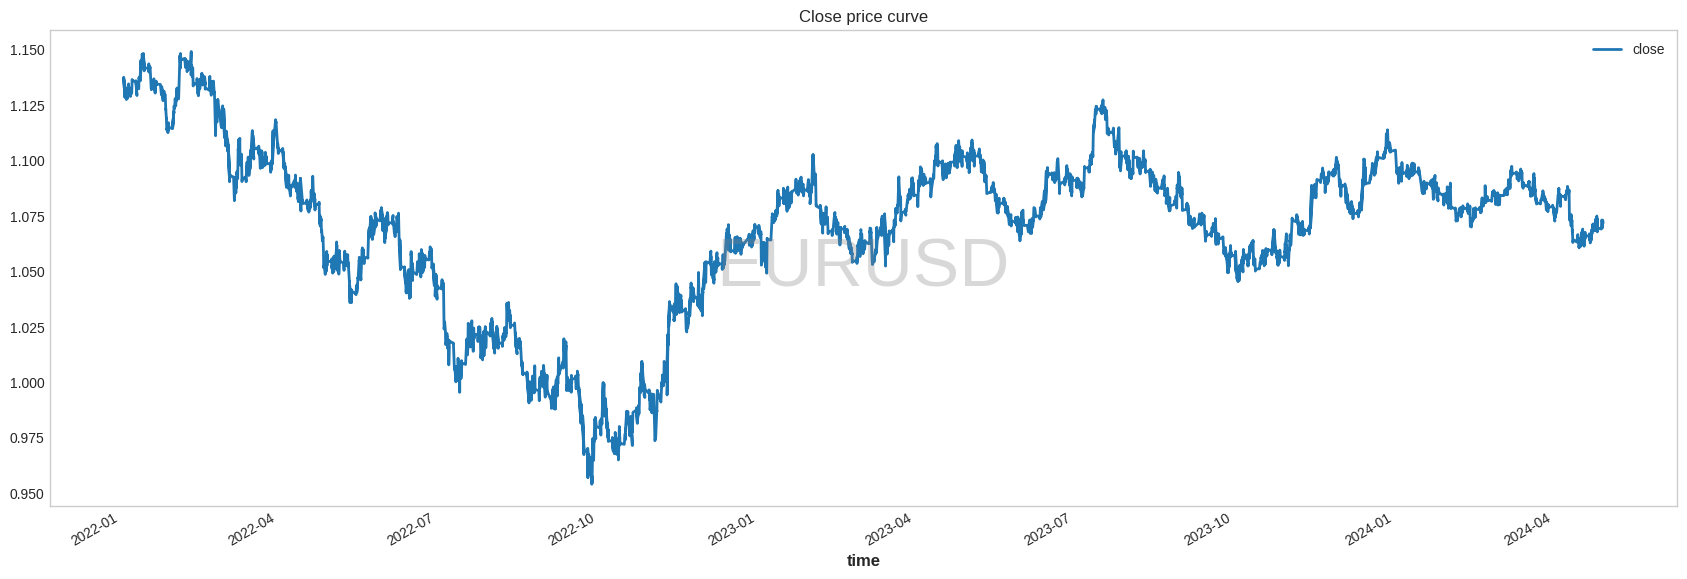

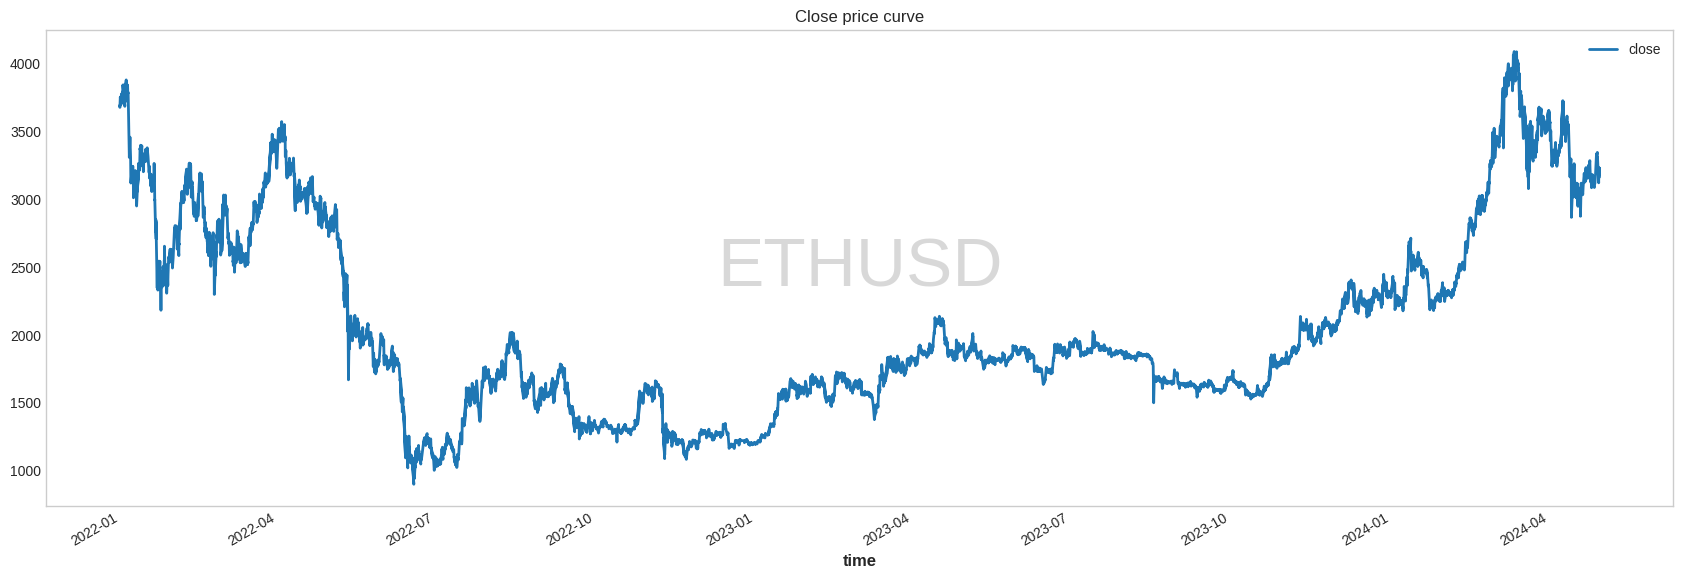

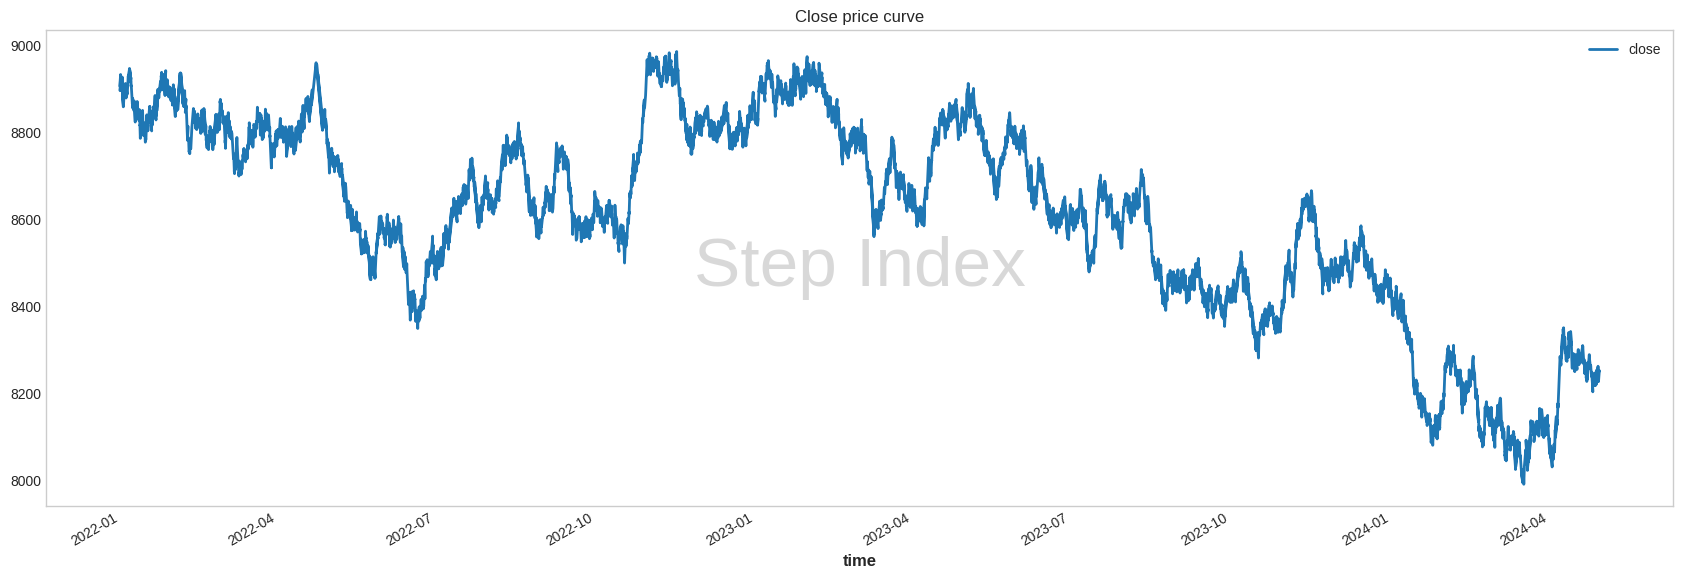

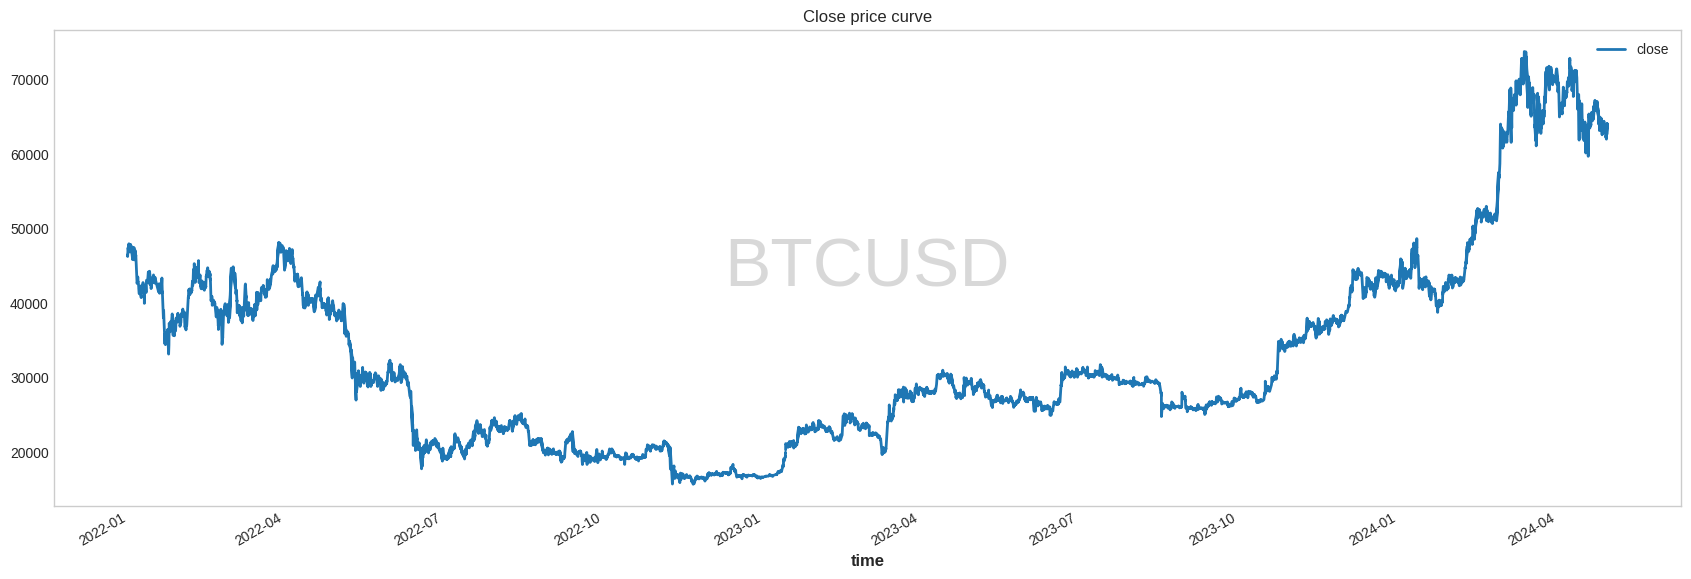

In [367]:
# Display
for name, data in processed_data_results.items():
    fig = plt.figure(figsize=(21, 7))

    # Plot the target label's data
    data['processed_df'][LABEL_TARGET].plot(label=LABEL_TARGET, title=f"{LABEL_TARGET} Price Curve".capitalize())

    # Add a watermark or name to the background
    plt.text(
    0.5, 0.5,                    # X and Y position (centered in the plot)
    name,                          # The text to display
    fontsize=50,                  # Font size for visibility
    color='gray',                 # Color of the watermark
    alpha=0.3,                    # Transparency level
    ha='center',                  # Horizontal alignment
    va='center',                  # Vertical alignment
    transform=plt.gca().transAxes  # Ensure the text is relative to the plot's axes
    )

    # Display grid and legend
    plt.grid()
    plt.legend()
    plt.show()


In [368]:
settings["features_name"] = processed_data_results['GBPUSD']['processed_df'].columns

settings["features_name"]

Index(['open', 'high', 'low', 'close', 'tick_volume', 'spread', 'real_volume',
       'returns', 'sLow', 'sHigh',
       ...
       'CDL_SPINNINGTOP', 'CDL_STALLEDPATTERN', 'CDL_STICKSANDWICH',
       'CDL_TAKURI', 'CDL_TASUKIGAP', 'CDL_THRUSTING', 'CDL_TRISTAR',
       'CDL_UNIQUE3RIVER', 'CDL_UPSIDEGAP2CROWS', 'CDL_XSIDEGAP3METHODS'],
      dtype='object', length=123)

### Apply Support and Resistance Detector 

In [369]:
from trade_flow.indicators.support_and_resistance import OptimizedSupportResistanceIndicator

df = processed_data_results['GBPUSD']['processed_df'].copy()

print("Dataset:", "\n")
df


Dataset: 



,open,high,low,close,tick_volume,spread,real_volume,returns,sLow,sHigh,...,CDL_SPINNINGTOP,CDL_STALLEDPATTERN,CDL_STICKSANDWICH,CDL_TAKURI,CDL_TASUKIGAP,CDL_THRUSTING,CDL_TRISTAR,CDL_UNIQUE3RIVER,CDL_UPSIDEGAP2CROWS,CDL_XSIDEGAP3METHODS
time,,,,,,,,,,,,,,,,,,,,,
2022-01-02 22:00:00,1.35205,1.35206,1.35184,1.35200,20,178,0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-02 22:15:00,1.35199,1.35265,1.35169,1.35253,46,147,0,0.000392,-0.000229,0.000481,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-02 22:30:00,1.35252,1.35334,1.35172,1.35304,135,102,0,0.000377,-0.000599,0.000599,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-02 22:45:00,1.35304,1.35304,1.35260,1.35266,39,102,0,-0.000281,-0.000325,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-02 23:00:00,1.35267,1.35353,1.35261,1.35264,402,1,0,-0.000015,-0.000037,0.000643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-29 22:00:00,1.25610,1.25640,1.25610,1.25630,204,3,0,0.000159,0.000000,0.000239,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-04-29 22:15:00,1.25629,1.25629,1.25608,1.25611,45,2,0,-0.000151,-0.000175,-0.000008,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-04-29 22:30:00,1.25611,1.25620,1.25602,1.25612,74,2,0,0.000008,-0.000072,0.000072,...,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [370]:
# Create an instance of SupportResistanceIndicator or OptimizedSupportResistanceIndicator
indicator = OptimizedSupportResistanceIndicator(df)

# Calculate Pivot Points
pivot_points_df = indicator.calculate_pivot_points()
print("Pivot Points and Support/Resistance Levels:\n")
pivot_points_df

Pivot Points and Support/Resistance Levels:



,Pivot,Resistance_1,Support_1,Resistance_2,Support_2,Resistance_3,Support_3
0,1.351967,1.352093,1.351873,1.352187,1.351747,1.352313,1.351653
1,1.352290,1.352890,1.351930,1.353250,1.351330,1.353850,1.350970
2,1.352700,1.353680,1.352060,1.354320,1.351080,1.355300,1.350440
3,1.352767,1.352933,1.352493,1.353207,1.352327,1.353373,1.352053
4,1.352927,1.353243,1.352323,1.353847,1.352007,1.354163,1.351403
...,...,...,...,...,...,...,...
57875,1.256267,1.256433,1.256133,1.256567,1.255967,1.256733,1.255833
57876,1.256160,1.256240,1.256030,1.256370,1.255950,1.256450,1.255820
57877,1.256113,1.256207,1.256027,1.256293,1.255933,1.256387,1.255847
57878,1.256080,1.256150,1.256040,1.256190,1.255970,1.256260,1.255930


In [371]:
# Detect Local Min/Max
support, resistance = indicator.detect_local_min_max(window_size=settings['horizon'])
print("\nDetected Support Levels:", support)
print("Detected Resistance Levels:", resistance)


Detected Support Levels: [(numpy.datetime64('2022-01-03T04:45:00.000000000'), 1.34954), (numpy.datetime64('2022-01-03T05:30:00.000000000'), 1.34954), (numpy.datetime64('2022-01-03T15:30:00.000000000'), 1.3430900000000001), (numpy.datetime64('2022-01-03T22:00:00.000000000'), 1.34543), (numpy.datetime64('2022-01-04T03:15:00.000000000'), 1.34631), (numpy.datetime64('2022-01-04T06:15:00.000000000'), 1.3459699999999999), (numpy.datetime64('2022-01-04T12:30:00.000000000'), 1.34789), (numpy.datetime64('2022-01-04T12:45:00.000000000'), 1.34789), (numpy.datetime64('2022-01-04T19:00:00.000000000'), 1.3520699999999999), (numpy.datetime64('2022-01-04T22:15:00.000000000'), 1.35226), (numpy.datetime64('2022-01-05T05:30:00.000000000'), 1.35226), (numpy.datetime64('2022-01-05T10:45:00.000000000'), 1.35281), (numpy.datetime64('2022-01-05T22:00:00.000000000'), 1.35466), (numpy.datetime64('2022-01-06T01:00:00.000000000'), 1.35378), (numpy.datetime64('2022-01-06T08:45:00.000000000'), 1.34903), (numpy.dat

In [372]:
pd.DataFrame(support, columns=['timestamp', 'lows'])

,timestamp,lows
0,2022-01-03 04:45:00,1.34954
1,2022-01-03 05:30:00,1.34954
2,2022-01-03 15:30:00,1.34309
3,2022-01-03 22:00:00,1.34543
4,2022-01-04 03:15:00,1.34631
...,...,...
2563,2024-04-26 15:00:00,1.24491
2564,2024-04-28 21:00:00,1.24604
2565,2024-04-29 09:00:00,1.25073
2566,2024-04-29 13:30:00,1.25145


In [373]:
pd.DataFrame(resistance, columns=['timestamp', 'highs'])

,timestamp,highs
0,2022-01-03 01:15:00,1.35298
1,2022-01-03 09:00:00,1.35284
2,2022-01-03 19:15:00,1.34860
3,2022-01-03 23:30:00,1.34852
4,2022-01-04 10:45:00,1.35150
...,...,...
2498,2024-04-26 19:00:00,1.25041
2499,2024-04-29 04:45:00,1.25482
2500,2024-04-29 08:30:00,1.25403
2501,2024-04-29 12:00:00,1.25436


In [374]:
def detect_sr_for_all(data_dict: dict, horizon: int = 2) -> dict:
    """
    Detect support and resistance levels (local maxima and minima) for each dataset in the given dictionary.

    Args:
        data_dict (dict): A dictionary where keys are dataset names and values are arrays of normalized data.
        horizon (int): The window size for detecting local maxima and minima (default is 2).

    Returns:
        dict: A dictionary where each key corresponds to a dataset name and each value is a tuple containing:
            - peaks_max (np.ndarray): Array of resistance (max) levels.
            - peaks_min (np.ndarray): Array of support (min) levels.
    """
    sr_results = {}

    for name, data in data_dict.items():
        # Initialize the indicator for detecting support and resistance levels
        detector = OptimizedSupportResistanceIndicator(data)

        # Detect local minima (support) and maxima (resistance) using the specified window size
        support_levels, resistance_levels = detector.detect_local_min_max(window_size=horizon)

        # Extract the resistance (highs) and support (lows) levels into numpy arrays
        peaks_max = pd.DataFrame(resistance_levels, columns=['timestamp', 'highs'])
        peaks_min = pd.DataFrame(support_levels, columns=['timestamp', 'lows'])

        # Store the results in the dictionary as (peaks_max, peaks_min)
        sr_results[name] = (peaks_max, peaks_min)

    return sr_results


In [375]:
def estimate_peak_distance(peaks_max, peaks_min):
    """
    Estimate peak distance between maximum and minimum peaks.

    Args:
        peaks_max (np.ndarray): Array of maximum peak values.
        peaks_min (np.ndarray): Array of minimum peak values.

    Returns:
        dict: A dictionary containing the mean and distance values for both peaks_max and peaks_min.
    """
    # Flatten the peak arrays
    peaks_max_flat = peaks_max.flatten()
    peaks_min_flat = peaks_min.flatten()

    # Calculate mean values
    mean_max = np.mean(peaks_max_flat)
    mean_min = np.mean(peaks_min_flat)

    # Calculate the difference between max peak and mean
    distance_max = np.max(peaks_max_flat) - mean_max
    distance_min = np.max(peaks_min_flat) - mean_min

    # Return results as a dictionary
    return {
        'mean_max': mean_max,
        'mean_min': mean_min,
        'distance_max': distance_max,
        'distance_min': distance_min
    }


In [376]:
# processed_data_results

In [377]:
peak_data_dict = {name: value['processed_df'] for name, value in processed_data_results.items()}
peak_data_dict

{'XAUUSD':                         open     high      low    close  tick_volume  spread  \
 time                                                                           
 2022-01-02 23:00:00  1830.61  1831.77  1829.52  1830.49          337       1   
 2022-01-02 23:15:00  1830.51  1830.75  1829.03  1829.26          304       8   
 2022-01-02 23:30:00  1829.17  1829.41  1828.47  1828.47          179       2   
 2022-01-02 23:45:00  1828.38  1828.54  1827.98  1828.47          190      13   
 2022-01-03 00:00:00  1828.47  1828.47  1827.43  1827.48          209      10   
 ...                      ...      ...      ...      ...          ...     ...   
 2024-04-29 22:00:00  2335.06  2336.34  2333.79  2335.95          511       7   
 2024-04-29 22:15:00  2336.00  2336.00  2334.78  2335.56          305       7   
 2024-04-29 22:30:00  2335.53  2335.53  2334.20  2334.86          448       7   
 2024-04-29 22:45:00  2334.86  2335.34  2334.21  2335.05          399       7   
 2024-04-29 23:00:

In [378]:
peaks_results = detect_sr_for_all(peak_data_dict, settings["horizon"])

peaks_results

{'XAUUSD': (               timestamp    highs
  0    2022-01-03 01:15:00  1831.52
  1    2022-01-03 10:15:00  1827.49
  2    2022-01-03 20:45:00  1804.56
  3    2022-01-04 02:15:00  1807.13
  4    2022-01-04 07:30:00  1807.39
  ...                  ...      ...
  2310 2024-04-26 12:30:00  2351.57
  2311 2024-04-26 18:30:00  2341.42
  2312 2024-04-29 05:00:00  2336.55
  2313 2024-04-29 09:45:00  2344.38
  2314 2024-04-29 16:15:00  2346.74
  
  [2315 rows x 2 columns],
                 timestamp     lows
  0    2022-01-03 07:00:00  1821.03
  1    2022-01-03 16:00:00  1798.35
  2    2022-01-03 23:00:00  1797.28
  3    2022-01-04 04:15:00  1803.18
  4    2022-01-04 07:00:00  1803.22
  ...                  ...      ...
  2337 2024-04-28 22:00:00  2332.60
  2338 2024-04-29 01:30:00  2319.98
  2339 2024-04-29 06:45:00  2327.53
  2340 2024-04-29 13:30:00  2325.69
  2341 2024-04-29 19:30:00  2333.01
  
  [2342 rows x 2 columns]),
 'XAGUSD': (               timestamp   highs
  0    2022-01-03 04

In [379]:
for name, peaks_result in peaks_results.items():
    peaks_max, peaks_min = peaks_result
    print(f"{name} => ", estimate_peak_distance(peaks_max['highs'].to_numpy(), peaks_min['lows'].to_numpy()))


XAUUSD =>  {'mean_max': 1914.612708423326, 'mean_min': 1904.3585012809565, 'distance_max': 516.8572915766738, 'distance_min': 486.08149871904357}
XAGUSD =>  {'mean_max': 22.95339321192053, 'mean_min': 22.723782920989628, 'distance_max': 6.839606788079468, 'distance_min': 6.188217079010371}
GBPUSD =>  {'mean_max': 1.245780083899321, 'mean_min': 1.242095175233645, 'distance_max': 0.12911991610067908, 'distance_min': 0.12952482476635496}
EURUSD =>  {'mean_max': 1.0711542811373649, 'mean_min': 1.0687462120031177, 'distance_max': 0.07836571886263499, 'distance_min': 0.07729378799688225}
ETHUSD =>  {'mean_max': 2064.23756791148, 'mean_min': 2011.687229053319, 'distance_max': 2034.1074320885205, 'distance_min': 2035.797770946681}
Step Index =>  {'mean_max': 8620.855850910142, 'mean_min': 8600.186761710795, 'distance_max': 364.9441490898571, 'distance_min': 369.91323828920576}
BTCUSD =>  {'mean_max': 32673.83206655756, 'mean_min': 31940.168823738062, 'distance_max': 41191.82993344244, 'distanc

In [380]:
peak_max

,timestamp,highs
0,2022-01-01 01:15:00,46915.200
1,2022-01-01 05:30:00,47537.800
2,2022-01-01 08:15:00,47340.500
3,2022-01-01 13:15:00,47195.500
4,2022-01-01 17:45:00,47997.300
...,...,...
3661,2024-04-28 13:15:00,63830.738
3662,2024-04-28 18:45:00,63954.638
3663,2024-04-29 01:30:00,63336.538
3664,2024-04-29 10:15:00,62657.438


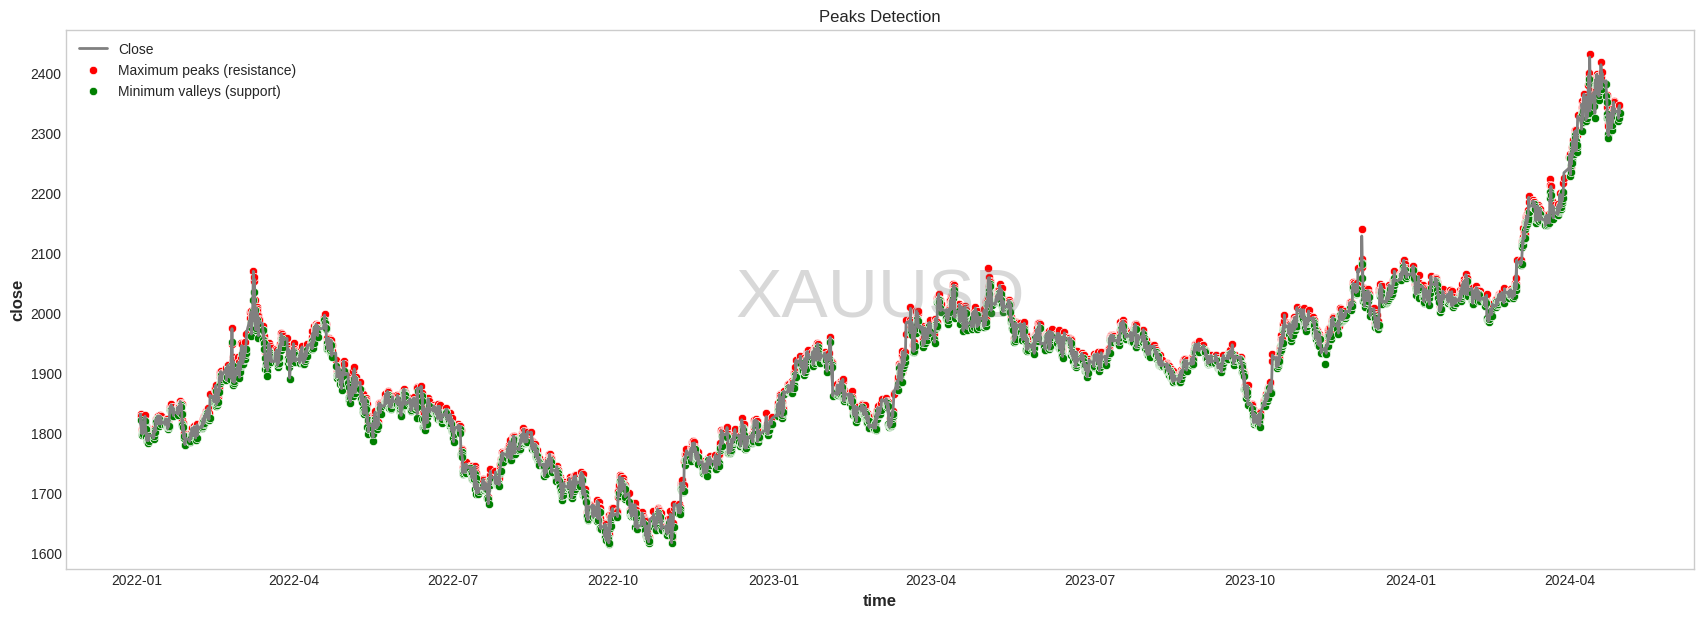

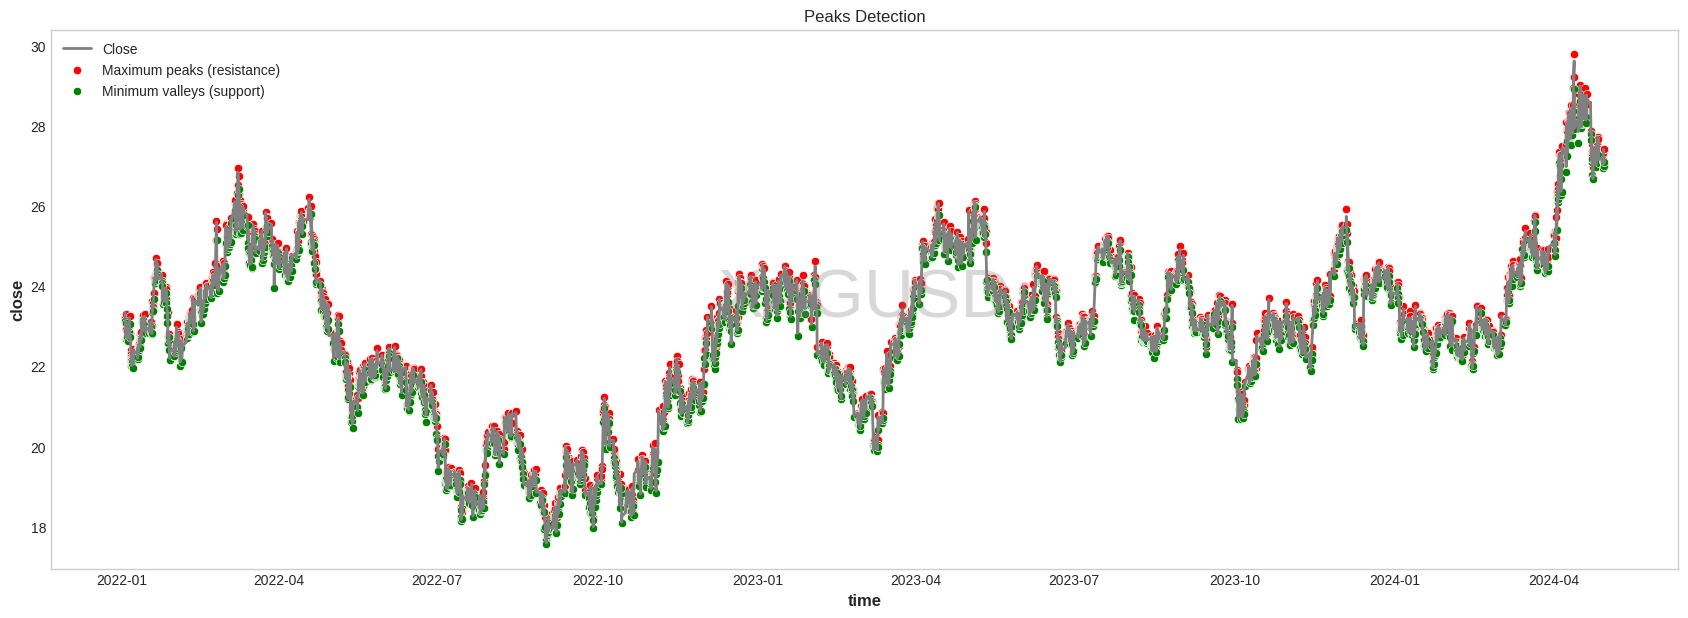

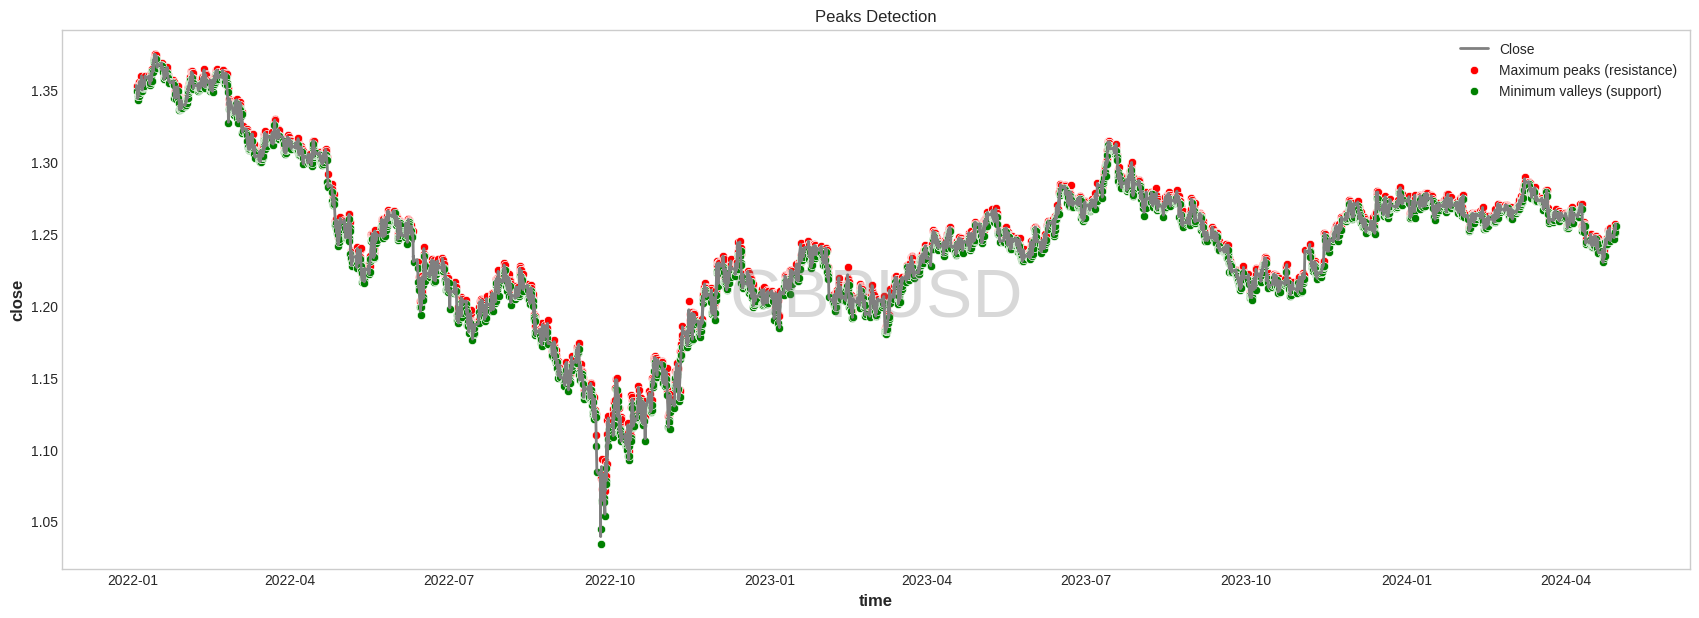

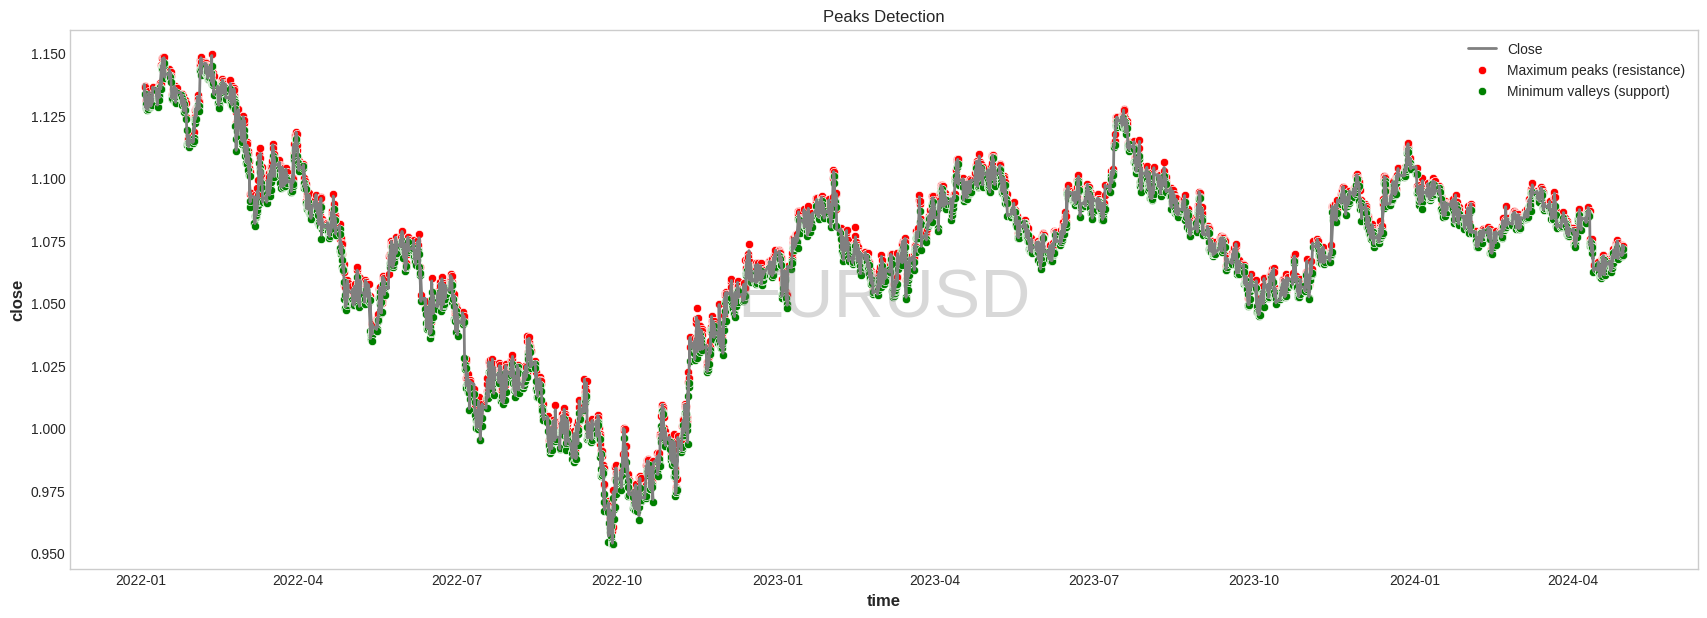

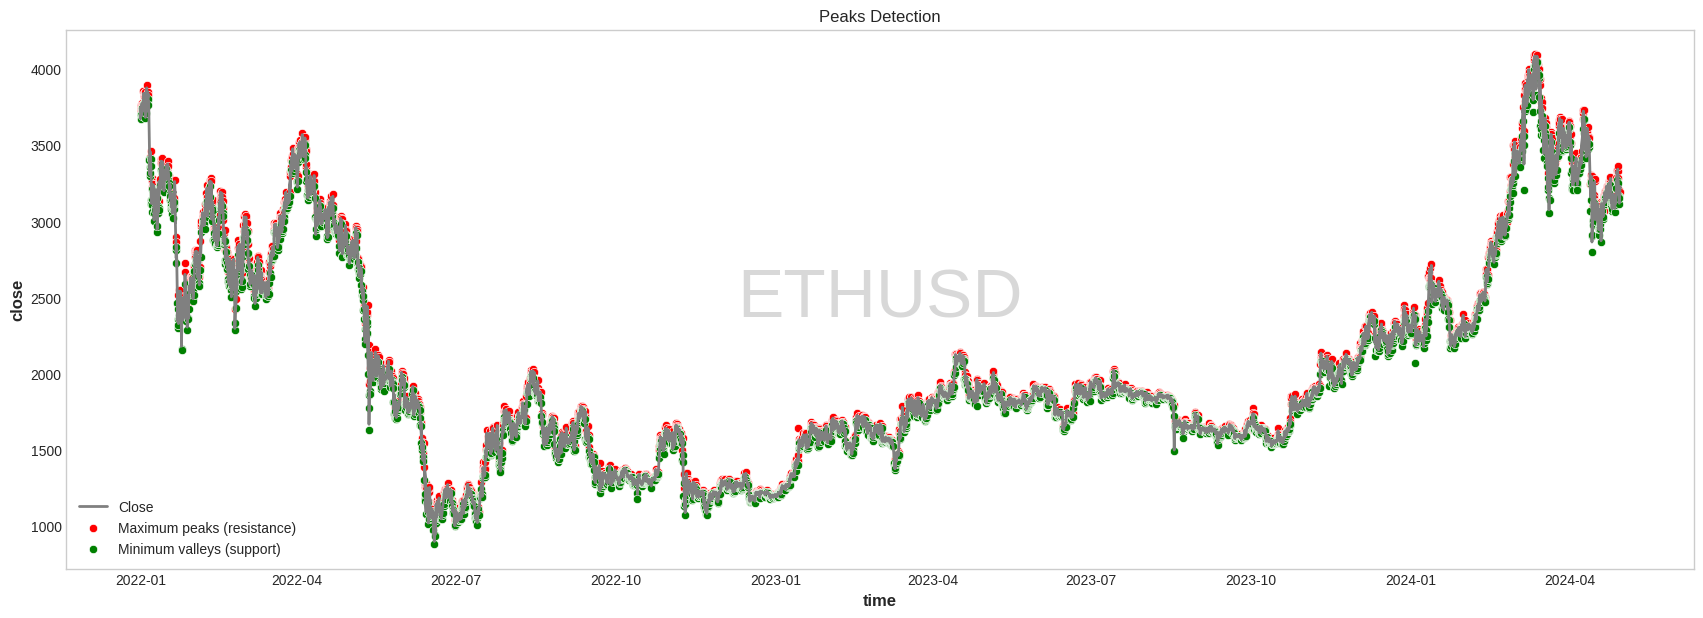

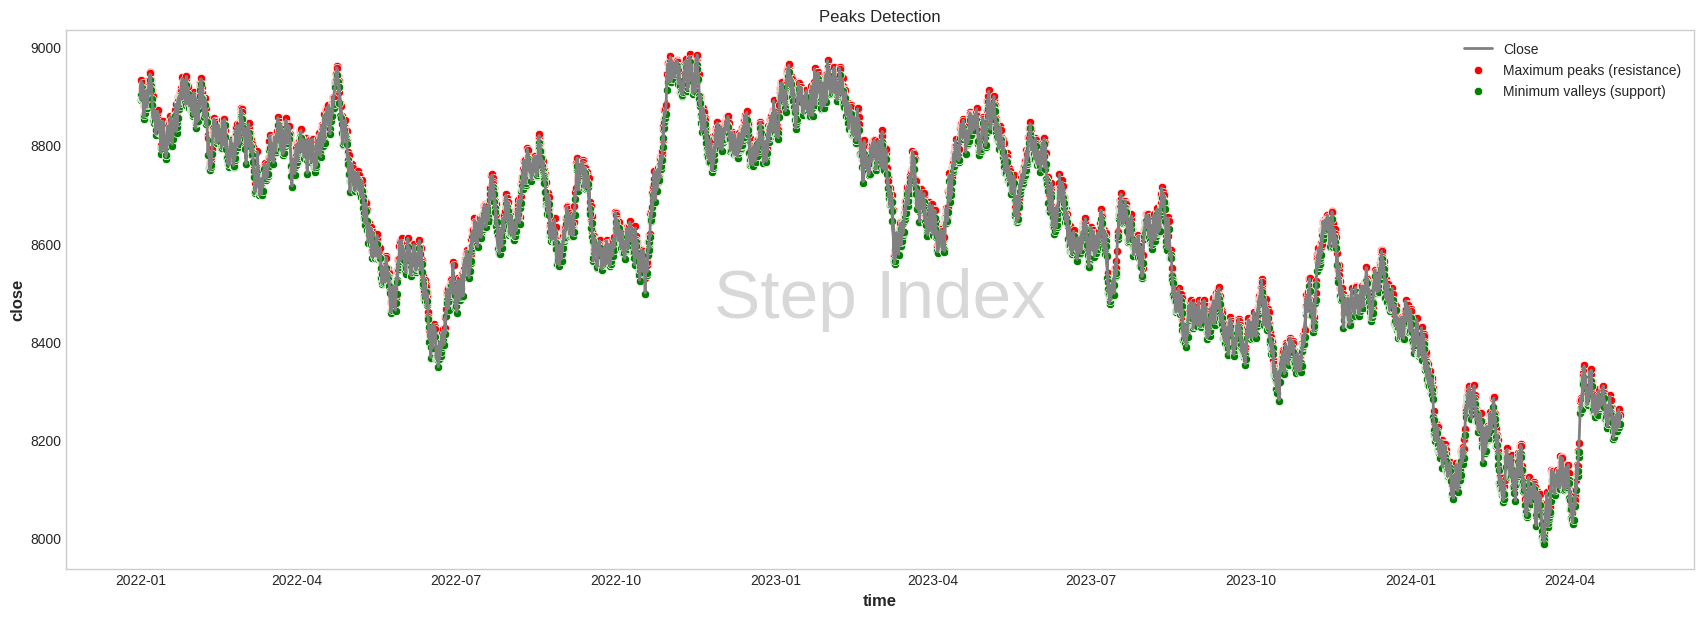

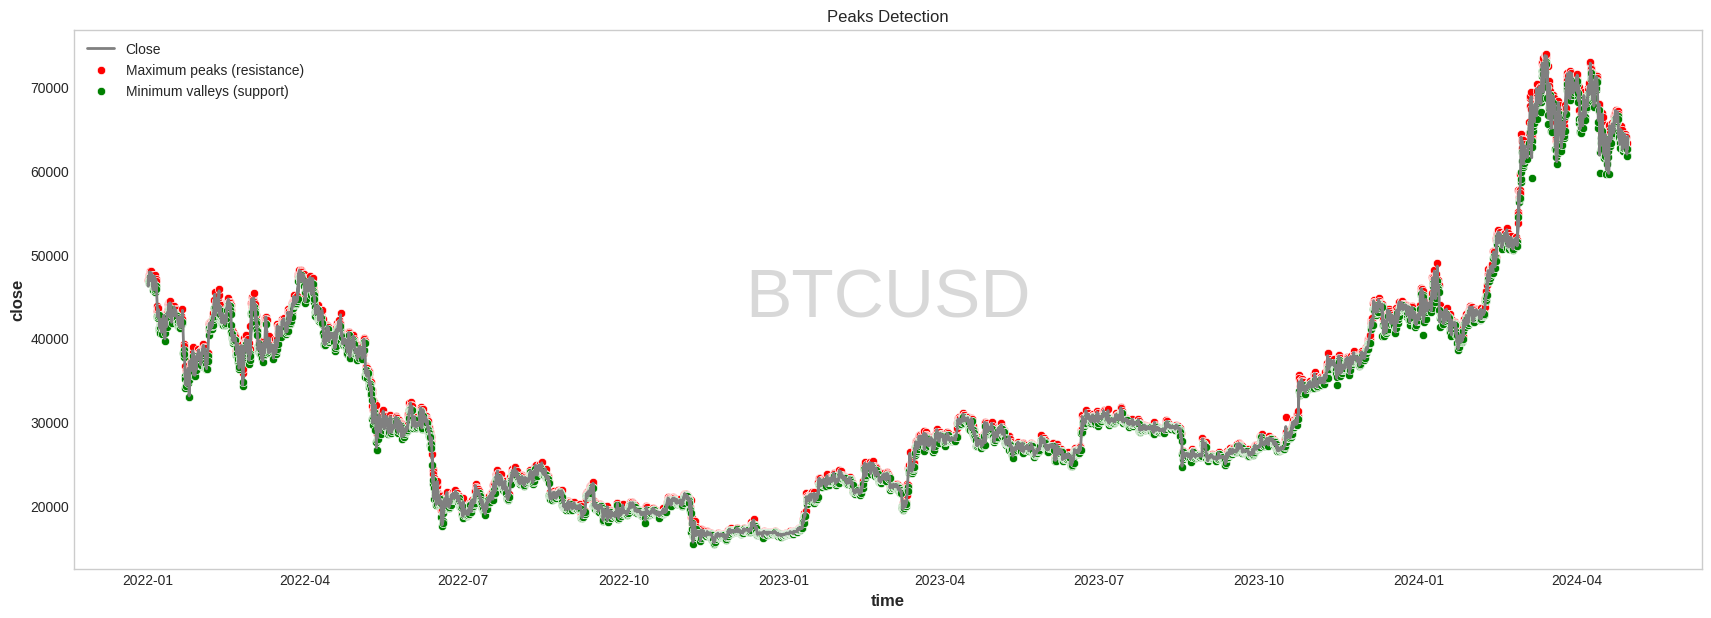

In [381]:
import seaborn as sns
import matplotlib.pyplot as plt

for name, peaks_result in peaks_results.items():
    peak_max, peak_min = peaks_result
    fig = plt.figure(figsize=(21, 7))
    
    actual_data = peak_data_dict[name]

    # Plot the actual data using Seaborn with a new color for the close price
    sns.lineplot(x=actual_data.index, y=actual_data[LABEL_TARGET], label=LABEL_TARGET.capitalize(), color='gray')
    
    # Plot the maximum peaks (red dots)
    sns.scatterplot(x=peak_max['timestamp'], y=peak_max['highs'], color='red', label="Maximum peaks (resistance)")

    # Plot the minimum valleys (green dots)
    sns.scatterplot(x=peak_min['timestamp'], y=peak_min['lows'], color='green', label="Minimum valleys (support)")

    # Add a watermark to the background
    plt.text(
        0.5, 0.5,                    # X and Y position (centered in the plot)
        name,                         # The text to display
        fontsize=50,                  # Font size for visibility
        color='gray',                 # Color of the watermark
        alpha=0.3,                    # Transparency level
        ha='center',                  # Horizontal alignment
        va='center',                  # Vertical alignment
        transform=plt.gca().transAxes  # Ensure the text is relative to the plot's axes
    )

    plt.grid()
    plt.title("Peaks Detection")
    plt.legend()
    plt.show()


### Apply Frame labelization

LABELIZATION WITH PEAKS

In [409]:

class ProbabilityCalculator:
    def __init__(self, df: pd.DataFrame, peaks_max: pd.DataFrame, peaks_min: pd.DataFrame, target_column: str = 'close'):
        """
        Initializes the ProbabilityCalculator with market data and peaks.

        Args:
            df (pd.DataFrame): The market data DataFrame with 'timestamp' in the index and the target data column.
            peaks_max (pd.DataFrame): A DataFrame containing 'timestamp' and 'highs' representing peak maxima.
            peaks_min (pd.DataFrame): A DataFrame containing 'timestamp' and 'lows' representing peak minima.
            target_column (str): The column of the market data to consider for labeling. Defaults to 'close'.
        """
        self.df = df
        self.peaks_max = peaks_max
        self.peaks_min = peaks_min
        self.target_column = target_column
        
        # Convert timestamps to the index
        self.df_timestamps = pd.to_datetime(df.index)
        self.peaks_max_timestamps = pd.to_datetime(peaks_max['timestamp'])
        self.peaks_min_timestamps = pd.to_datetime(peaks_min['timestamp'])

    def calculate_probabilities(self, method='proximity', **kwargs):
        """
        Calculates the probabilities using the specified method.

        Args:
            method (str): The method to use for calculating probabilities. Options are 'proximity', 'atr', 'std_dev'.
            **kwargs: Additional arguments for specific methods.
        
        Returns:
            np.array: The calculated probabilities.
        """
        if method == 'proximity':
            return self._calculate_proximity_probabilities(**kwargs)
        elif method == 'atr':
            return self._calculate_atr_probabilities(**kwargs)
        elif method == 'std_dev':
            return self._calculate_std_dev_probabilities(**kwargs)
        else:
            raise ValueError("Invalid method. Choose from 'proximity', 'atr', or 'std_dev'.")

    def _calculate_proximity_probabilities(self, scale=1000):
        """
        Calculates probabilities based on proximity to peaks.

        Args:
            scale (int, optional): The scale factor for proximity-based probability. Defaults to 1000.

        Returns:
            np.array: An array of probabilities.
        """
        probabilities = np.zeros(len(self.df))

        def distance_to_probability(distance, scale=1000):
            return np.exp(-distance / scale)
        
        for i, timestamp in enumerate(self.df_timestamps):
            closest_peak_max_distance = abs((self.peaks_max_timestamps - timestamp).min().total_seconds())
            closest_peak_min_distance = abs((self.peaks_min_timestamps - timestamp).min().total_seconds())
            
            prob_max = distance_to_probability(closest_peak_max_distance, scale)
            prob_min = distance_to_probability(closest_peak_min_distance, scale)
            
            probabilities[i] = max(prob_max, prob_min)
        
        return probabilities

    def _calculate_atr_probabilities(self, period=14):
        """
        Calculates probabilities based on Average True Range (ATR).

        Args:
            period (int, optional): The look-back period for calculating ATR. Defaults to 14.

        Returns:
            np.array: An array of probabilities.
        """
        high_low = self.df['high'] - self.df['low']
        high_close = np.abs(self.df['high'] - self.df['close'].shift())
        low_close = np.abs(self.df['low'] - self.df['close'].shift())
        tr = high_low.combine(high_close, max).combine(low_close, max)
        atr = tr.rolling(window=period).mean()
        
        # Normalize ATR values into probabilities
        probabilities = (atr / atr.max()).fillna(0).to_numpy()
        
        return probabilities

    def _calculate_std_dev_probabilities(self, period=14):
        """
        Calculates probabilities based on Standard Deviation.

        Args:
            period (int, optional): The look-back period for calculating standard deviation. Defaults to 14.

        Returns:
            np.array: An array of probabilities.
        """
        std_dev = self.df[self.target_column].rolling(window=period).std()
        
        # Normalize standard deviation into probabilities
        probabilities = (std_dev / std_dev.max()).fillna(0).to_numpy()
        
        return probabilities


In [ ]:
def label_all(data_dict: dict, target: str = 'close', method: str = 'proximity', probability_threshold: float = 0.75):
    """
    Labels market data for multiple datasets contained in a dictionary using the MarketLabeler.

    Args:
        data_dict (dict): A dictionary where each key is a name (str) and each value is a tuple containing:
                          - peaks_max (pd.DataFrame): A DataFrame representing peak maxima ('timestamp', 'highs').
                          - peaks_min (pd.DataFrame): A DataFrame representing peak minima ('timestamp', 'lows').
                          - df (pd.DataFrame): A DataFrame containing market data.
        target (str, optional): The name of the column to label in the DataFrame. Defaults to 'close'.
        method (str, optional): The method to use for probability calculation. Defaults to 'proximity'.
        probability_threshold (float, optional): The threshold for strong buy/sell signals. Defaults to 0.75.

    Returns:
        dict: A dictionary where each key is the name and the value is the labeled DataFrame.
    """
    
    labels_results = {}

    for name, data in data_dict.items():
        peaks_max, peaks_min, df = data

        # # Initialize the ProbabilityCalculator
        # calculator = ProbabilityCalculator(df, peaks_max, peaks_min, target_column=target)
        
        # # Calculate probabilities using the specified method
        # probabilities_array = calculator.calculate_probabilities(method=method)

        probabilities_array = None 

        # Convert peaks_max and peaks_min DataFrame columns to numpy arrays if necessary
        if isinstance(peaks_max, pd.DataFrame):
            peaks_max = peaks_max.to_numpy()
        if isinstance(peaks_min, pd.DataFrame):
            peaks_min = peaks_min.to_numpy()
        
        # Initialize the MarketLabeler with the peaks
        labeler = MarketLabeler(peaks_max, peaks_min)
        
        # Label the DataFrame using the specified target and calculated probabilities array
        labels_results[name] = labeler.label_dataframe(
            df, 
            data_column=target, 
            probabilities_array=probabilities_array, 
            probability_threshold=probability_threshold
        )

    return labels_results


In [411]:
label_data_dict = {}

for name, value in processed_data_results.items():
    df = value['processed_df']
    df.index.set_names('timestamp', inplace=True)
    
    peak_max, peak_min = peaks_results[name]  
    label_data_dict[name] = (peak_max, peak_min, df) 

label_data_dict


{'XAUUSD': (               timestamp    highs
  0    2022-01-03 01:15:00  1831.52
  1    2022-01-03 10:15:00  1827.49
  2    2022-01-03 20:45:00  1804.56
  3    2022-01-04 02:15:00  1807.13
  4    2022-01-04 07:30:00  1807.39
  ...                  ...      ...
  2310 2024-04-26 12:30:00  2351.57
  2311 2024-04-26 18:30:00  2341.42
  2312 2024-04-29 05:00:00  2336.55
  2313 2024-04-29 09:45:00  2344.38
  2314 2024-04-29 16:15:00  2346.74
  
  [2315 rows x 2 columns],
                 timestamp     lows
  0    2022-01-03 07:00:00  1821.03
  1    2022-01-03 16:00:00  1798.35
  2    2022-01-03 23:00:00  1797.28
  3    2022-01-04 04:15:00  1803.18
  4    2022-01-04 07:00:00  1803.22
  ...                  ...      ...
  2337 2024-04-28 22:00:00  2332.60
  2338 2024-04-29 01:30:00  2319.98
  2339 2024-04-29 06:45:00  2327.53
  2340 2024-04-29 13:30:00  2325.69
  2341 2024-04-29 19:30:00  2333.01
  
  [2342 rows x 2 columns],
                          open     high      low    close  tick_vo

In [ ]:
%%time

# Label all datasets
labeled_results = label_all(label_data_dict, target=LABEL_TARGET, probability_threshold=settings['label_disparity'])


In [413]:
# Display results
for name, labeled_df in labeled_results.items():
    print(f"{name} labeled data:\n{labeled_df}\n")

In [414]:
labeled_normalize_df

NameError: name 'labeled_normalize_df' is not defined

In [ ]:
stop

### Apply Nomalization

In [ ]:
ndata = []

for name, data in processed_data_results.items():
    ndata.append({"name": name, "data": data['processed_df']})


In [ ]:
# NORMALIZATION OF THE DATA
norm = Normalizer(data=ndata)
norm.fit(settings["normalization_fit_type"], settings["features_name"], settings["normalization_fit_target"])


Performing StandardScale Normalization on all.


In [ ]:
normalize_data_dict = {}

count = 0
for name, data in processed_data_results.items():
    normalize_data_dict[name] = norm.get_normalized_data(count)
    count += 1


In [ ]:
normalize_data_dict['GBPUSD']

,open,high,low,close,tick_volume,spread,real_volume,returns,sLow,sHigh,...,CDL_SPINNINGTOP,CDL_STALLEDPATTERN,CDL_STICKSANDWICH,CDL_TAKURI,CDL_TASUKIGAP,CDL_THRUSTING,CDL_TRISTAR,CDL_UNIQUE3RIVER,CDL_UPSIDEGAP2CROWS,CDL_XSIDEGAP3METHODS
0,0.535022,0.546187,0.539368,0.549624,-0.537955,2.889401,0.0,NaN,NaN,NaN,...,-0.01,0.047931,-0.006341,-0.163050,0.012684,0.026914,-0.00339,-0.008968,0.0,-0.003124
1,0.549662,0.553944,0.562509,0.551972,-0.671041,0.013822,0.0,0.099047,0.803726,0.112680,...,-0.01,0.047931,-0.006341,-0.163050,0.012684,0.026914,-0.00339,-0.008968,0.0,-0.003124
2,0.552148,0.556021,0.561132,0.561088,-0.261545,0.013822,0.0,0.382842,0.605381,0.097621,...,-0.01,0.047931,-0.006341,-0.163050,0.012684,0.026914,-0.00339,-0.008968,0.0,-0.003124
3,0.561126,0.561701,0.569534,0.559845,0.022862,0.013822,0.0,-0.051532,0.568774,-0.089475,...,-0.01,0.047931,-0.006341,-0.163050,0.012684,0.026914,-0.00339,-0.008968,0.0,-0.003124
4,0.559607,0.547295,0.557413,0.549900,-0.341845,0.013822,0.0,-0.416275,-0.011343,-0.798704,...,-0.01,0.047931,-0.006341,-0.163050,0.012684,0.026914,-0.00339,-0.008968,0.0,-0.003124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24863,-0.151706,-0.130470,-0.138206,-0.121509,0.638384,-0.177883,0.0,1.319743,0.734381,1.214113,...,-0.01,0.047931,-0.006341,-0.163050,0.012684,0.026914,-0.00339,-0.008968,0.0,-0.003124
24864,-0.121458,-0.136426,-0.135313,-0.141675,1.203680,-0.177883,0.0,-0.877370,-0.775593,-0.821102,...,-0.01,0.047931,-0.006341,-0.163050,0.012684,0.026914,-0.00339,-0.008968,0.0,-0.003124
24865,-0.141623,-0.154433,-0.146471,-0.144713,0.039817,-0.177883,0.0,-0.131874,-0.281105,-0.696886,...,-0.01,0.047931,-0.006341,6.133099,0.012684,0.026914,-0.00339,-0.008968,0.0,-0.003124
24866,-0.143971,-0.145845,-0.130906,-0.141675,-0.042401,-0.177883,0.0,0.133037,0.749688,-0.044614,...,-0.01,0.047931,-0.006341,-0.163050,0.012684,0.026914,-0.00339,-0.008968,0.0,-0.003124


### Apply Data Generator - Split Normalized Data

horizon (int): The number of forward terms of the target time series to be estimated

In [62]:
data_generator = DataGenerator(labeled_normalize_df, settings["horizon"], settings["features_name"], settings["labels_name"])


In [ ]:
%%time
x_train, y_train, x_test, y_test = data_generator.train_test_split(settings["split_test"], settings["is_balance"])


In [ ]:
x_train.shape, y_train.shape

In [ ]:
x_train.dtype, y_train.dtype


In [ ]:
y_train[0]

### Model Experiments

In [67]:
# from keras.layers import Input, Dense, Dropout, Bidirectional, Reshape
# from keras.callbacks import EarlyStopping
# from keras.metrics import F1Score, FBetaScore, Precision, Recall 
# from tcn import TCN, tcn_full_summary

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import Adam
from pytorch_tcn import TCN

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# https://github.com/paul-krug/pytorch-tcn
# https://github.com/locuslab/TCN/

#### Define Model Util functions (for Neural Nets)

In [68]:
def calculate_lstm_neurons(data_array: np.array, settings: dict) -> int:
    """
    Calculates the number of neurons for an LSTM network based on data and settings.

    Args:
        data_array (np.array): The numpy array containing the training data.
        settings (dict): A dictionary containing settings for neuron calculation.
            - features_name (list): Names of features for training.
            - labels_name (list): Names of output labels (classes).
            - delta_neurons_numbers (int): Hyperparameter scaling the number of neurons.

    Returns:
        int: The calculated number of neurons for the LSTM network.

    Raises:
        ValueError: If required keys are missing from the settings dictionary.
    """

    if not all(key in settings for key in ["features_name", "labels_name", "delta_neurons_numbers"]):
        raise ValueError("Missing required keys in 'settings' dictionary.")

    num_features = len(settings["features_name"])
    num_labels = len(settings["labels_name"])
    num_samples = data_array.shape[0]
    scaling_factor = settings["delta_neurons_numbers"]

    return int(num_samples / (scaling_factor * (num_features + num_labels)))


In [69]:
from torch.utils.data import TensorDataset, DataLoader

def create_train_test_set(x_train, x_test, y_train, y_test):
    """Creates train and test datasets from numpy arrays or lists.

    Args:
        x_train: Training features.
        x_test: Test features.
        y_train: Training labels.
        y_test: Test labels.

    Returns:
        training_data: A TensorDataset for the training set.
        test_data: A TensorDataset for the test set.
    """
    # Convert to torch tensors
    tensor_x_train = torch.Tensor(x_train)
    tensor_y_train = torch.Tensor(y_train)
    training_data = TensorDataset(tensor_x_train, tensor_y_train)  # Create training dataset

    tensor_x_test = torch.Tensor(x_test)
    tensor_y_test = torch.Tensor(y_test)
    test_data = TensorDataset(tensor_x_test, tensor_y_test)  # Create test dataset

    return training_data, test_data


In [ ]:
# https://stackoverflow.com/questions/40761185/what-is-the-intuition-of-using-tanh-in-lstm
# x_tcn = GlobalAveragePooling1D()(x_tcn)
 
# SET NUMBER OF NEURONS
settings["model_neural"] = calculate_lstm_neurons(x_train, settings)  
settings["model_neural_hidden"] =  settings["model_neural"] + int(settings["model_neural"] / 2) # int(settings["model_neural"] / 2)

settings["model_neural"], settings["model_neural_hidden"]

In [71]:
# Model parameters
input_dim = x_train.shape[2]  # Feature size per time step (input dimension)
hidden_dim_1 = settings["model_neural"]  # Hidden layer size
hidden_dim_2 = settings["model_neural_hidden"]  # Hidden layer size
output_dim = y_train.shape[1]  # Number of output classes
device = "cpu"
models = {}
trained_models = {}

In [72]:
training_data, test_data = create_train_test_set(x_train, x_test, y_train, y_test)

train_dataloader = DataLoader(training_data, batch_size=settings["model_batch_size"], shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=settings["model_batch_size"], shuffle=False)

#### Model A (Bi-LSTM)

In [ ]:
class BidirectionalLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers: int = 4, **kwargs):
        super(BidirectionalLSTMModel, self).__init__()

        self.hidden_size = hidden_size or 24

        self.num_layers = num_layers

        # Bidirectional LSTMs
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=0.2)

        # Dropout layer
        # self.dropout = nn.Dropout(0.2)

        # Dense (fully connected) layer with softmax activation
        self.fc = nn.Linear(hidden_size*2, output_size) 

    def forward(self, x):
        # Set initial hidden and cell states 
        # h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        # c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)

        # Passing input through LSTMs
        out, _ = self.bilstm(x) # out, hidden = self.bilstm(x, (h0, c0))
        # out = self.dropout(out)

        # Taking the output of the last time step
        out = out[:, -1, :]

        fc = self.fc(out)
        x = F.softmax(fc)
        return x


# Model instantiation
models["BidirectionalLSTM"] = BidirectionalLSTMModel(input_size=input_dim, hidden_size=hidden_dim_1, output_size=output_dim)

# Summary 
print(models["BidirectionalLSTM"])


#### Model B (Bi-GRU)

In [ ]:
class BidirectionalGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers: int = 4, **kwargs):
        super(BidirectionalGRUModel, self).__init__()

        self.hidden_size = hidden_size or 24

        self.num_layers = num_layers

        # Bidirectional GRU layers
        self.bigru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=0.2)
        
        # Dense (fully connected) layer with softmax activation
        self.fc = nn.Linear(hidden_size*2, output_size) 
        
    def forward(self, x):
        # Forward pass through bidirectional GRU layers
        out, _ = self.bigru(x)
        
        # Taking the output of the last time step
        out = out[:, -1, :]

        fc = self.fc(out)
        x = F.softmax(fc)
        return x

models["BidirectionalGRU"] = BidirectionalGRUModel(input_size=input_dim, hidden_size=hidden_dim_1, output_size=output_dim)

# Summary 
print(models["BidirectionalGRU"])

#### Model C (TCN)

In [ ]:
class TCNModel(nn.Module):
    def __init__(self, input_size, output_size, num_channels: Tuple = (2, 3, 5, 8, 16, 32), kernel_size: int = 5, dilations: Tuple = (1, 2, 4, 8, 16, 32)):
        super(TCNModel, self).__init__()

        # Define the TCN layer with appropriate parameters
        self.tcn = TCN(input_size, num_channels, kernel_size, dilations, input_shape='NLC', dropout=0.2)

        # Fully connected layer with input size matching the last TCN channel size
        self.fc = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        # Passing input through the TCN layer
        out = self.tcn(x)

        # Taking the output of the last time step
        out = out[:, -1, :]

        # Pass through the fully connected layer
        fc = self.fc(out)
        
        x = F.softmax(fc)
        return x  


# Model instantiation
models["TCN"] = TCNModel(input_size=input_dim, output_size=output_dim)

# Summary 
print(models["TCN"])


In [ ]:
models

#### Training


In [77]:
def train_model(model: nn.Module,
                model_optimizer: str,
                model_loss: str,
                num_epochs: int = 20,
                dataloader: Optional[DataLoader] = None,
                device: Optional[str] = None) -> tuple[nn.Module, optim.Optimizer, nn.Module]:
    """Trains a PyTorch model.

    Args:
        model: The PyTorch model to train.
        model_optimizer: The name of the optimizer to use.
        model_loss: The name of the loss function to use.
        num_epochs: The number of epochs to train for.
        dataloader: The DataLoader object for loading data.
        device: The device to use for training (e.g., 'cpu', 'cuda').

    Returns:
        A tuple containing the trained model, optimizer, and loss function.
    """

    if dataloader is None:
        raise ValueError("A DataLoader object must be provided.")

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    # Optimizer
    optimizer_class = getattr(optim, model_optimizer.capitalize())
    optimizer = optimizer_class(model.parameters())

    # Loss function
    loss_function = getattr(nn, model_loss)()

    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

    return model, optimizer, loss_function

In [ ]:
for name, model in models.items(): 
    print(f"{name} Model:")
    trained_models[name] = train_model(models[name], settings["model_optimizer"], settings["model_loss"], settings['model_epoch'], train_dataloader)


In [79]:
# # Plot real-time
# plotRT = PlotRealTime()

# # Learning stats
# def lr(epoch):
#     if epoch < 15:
#         return 0.0001 # 0.010
#     if epoch < 40:
#         return 0.0095
#     if epoch < 55:
#         return 0.008
#     if epoch < 60:
#         return 0.007
#     if epoch < 150:
#         return 0.0001 # 0.01
    
#     return 0.0001

# def lr2(epoch):
#     if epoch < 100:
#         return 1e-8
    
#     return 1e-4


# # Define early stopping callback
# patience = 25
# early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)


# plotter = PlotRealTime()
# history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[plotter])


# %%time
# hist_a = model_a.fit(x_train,
#                  y_train, 
#                  epochs=settings["model_epoch"],
#                  batch_size=settings["model_batch_size"],
#                  validation_split=settings["model_validation_split"],
#                  verbose=1,
#                  shuffle=settings["model_shuffle"],
#                  callbacks=[plotRT, early_stopping, LearningRateScheduler(lr, verbose=1)])

# model_a.save(f"../models/{file_name}_model_a_{time.time()}.h5")

#### Evaluate

np.argmax(y_test, axis=1) => {0: 'BUY', '1': 'SELL', 2: 'NEUTRAL'}

In [80]:
metrics = {}

In [81]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from typing import Tuple, Optional

def evaluate_model(trained_model: Tuple[nn.Module, Optimizer, nn.Module],
                   dataloader: DataLoader,
                   device: Optional[str] = None) -> dict:
    """Evaluates a PyTorch model on a given dataset.

    Args:
        trained_model: A tuple containing the trained PyTorch model, optimizer, and loss function.
        dataloader: The DataLoader object for loading evaluation data.
        device: The device to use for evaluation (e.g., 'cpu', 'cuda').

    Returns:
        A dictionary containing evaluation metrics like accuracy, precision, recall, F1 score, and confusion matrix.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model, optimizer, loss_function = trained_model
    model.to(device)
    model.eval()  # Set the model to evaluation mode


    raw_targets = []
    raw_predictions = []
    all_targets = []
    all_predictions = []
    total_loss = 0

    # Loss function for evaluation 
    criterion = loss_function

    with torch.no_grad():  # Disable gradient calculation during evaluation
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            raw_targets.extend(targets.cpu().numpy())
            raw_predictions.extend(outputs.cpu().numpy())

            # Convert outputs to predicted class (taking the argmax for multi-class classification)
            _, predicted = torch.max(outputs, 1)

            # If targets are one-hot encoded, convert them to class indices
            if len(targets.shape) > 1 and targets.shape[1] > 1:
                targets = torch.argmax(targets, dim=1)

            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')
    f1 = f1_score(all_targets, all_predictions, average='weighted')

    # Confusion matrix
    conf_matrix = confusion_matrix(all_targets, all_predictions)

    # Return the evaluation metrics in a dictionary
    metrics = {
        "loss": total_loss / len(dataloader),
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": conf_matrix,
        "raw_targets": raw_targets,
        "raw_predictions": raw_predictions,
    }

    # Display the metrics
    print(f"Evaluation Loss: {metrics['loss']:.4f}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print(f"Confusion Matrix:\n{metrics['confusion_matrix']}")

    return metrics


In [ ]:
for name, model in trained_models.items():
    print(f"{name} Model:")
    metrics[name] = evaluate_model(trained_models[name], test_dataloader)
    

##### Performance Table

In [ ]:
dl_results = pd.DataFrame(metrics).T.drop(columns=['raw_targets', 'raw_predictions'])

dl_results

##### Confusion Matrix

In [84]:
import seaborn as sns

def plot_confusion_matrix(conf_matrix, label_map: dict = {0: 'BUY', 1: 'SELL', 2: 'NEUTRAL'}):
    """Plots the confusion matrix using a heatmap.

    Args:
        conf_matrix: The confusion matrix to plot (numpy array or similar).
        label_map: A dictionary mapping label indices to actual class names.

    Returns:
        None. Displays the confusion matrix plot.
    """
    plt.figure(figsize=(10, 8))
    ax = plt.subplot()

    # Create heatmap with the confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax)  # annot=True to annotate cells, fmt='g' for plain numbers

    # Add labels, title, and ticks
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('Actual Labels')
    ax.set_title('Confusion Matrix')

    # Set tick labels based on label_map
    labels = list(label_map.values())
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

    # Show the plot
    plt.show()


In [ ]:
for name, metric in metrics.items():
    print(f"{name} Model:")
    conf_matrix = metric['confusion_matrix']
    plot_confusion_matrix(conf_matrix, label_map={0: 'BUY', 1: 'SELL', 2: 'NEUTRAL'})
    

##### ROC curve

In [86]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curve(y_pred, y_test, classes=[0, 1, 2]):
    """
    Plots the ROC curves for multi-class classification.

    Args:
        y_pred (numpy array): Predicted probabilities for each class, shape (n_samples, n_classes).
        y_test (numpy array): True class labels, shape (n_samples,).
        classes (list): List of classes. Default is [0, 1, 2].

    Returns:
        None. Displays the ROC curve plot.
    """
    # Binarize the output for multi-class ROC
    y_test_bin = label_binarize(y_test, classes=classes)
    n_classes = len(classes)

    # Initialize dictionaries to store False Positive Rates, True Positive Rates, and AUCs for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute ROC curve and AUC for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    # Interpolate all ROC curves and compute the mean True Positive Rate (macro-average)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot the ROC curves
    plt.figure(figsize=(10, 8))

    # Micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
             color='blue', linestyle=':', linewidth=4)

    # Macro-average ROC curve
    plt.plot(fpr["macro"], tpr["macro"],
             label=f'Macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
             color='navy', linestyle=':', linewidth=4)

    # ROC curves for each class
    colors = ['aqua', 'darkorange', 'cornflowerblue']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')

    # Plot the diagonal (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    # Add labels, title, and legend
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


In [ ]:
for name, metric in metrics.items():
    print(f"{name} Model:")

    # Convert lists of arrays to 2D NumPy arrays
    raw_predictions = np.array(metric['raw_predictions'])
    raw_targets = np.array(metric['raw_targets'])

    plot_roc_curve(raw_predictions, raw_targets)
    

#### Save Models

In [88]:
from pathlib import Path

model_dir = Path(os.getcwd()).parent / 'models'
# model_dir = os.path.join(os.getcwd(), 'models')
# os.makedirs(model_dir, exist_ok=True)  # Create directory if it doesn't exist


def save_model(trained_model: Tuple[nn.Module, optim.Optimizer, nn.Module], path: str) -> None:
    """
    Saves the complete training state of a PyTorch model to a file.

    This function saves the model's state dictionary, containing the learned
    parameters (weights and biases), along with the state dictionaries of the
    optimizer and the loss function. This allows you to load the entire training
    state later and resume training from the saved point or use the model for
    inference.

    Args:
        trained_model: A tuple containing the trained PyTorch model (nn.Module),
                       optimizer (optim.Optimizer), and loss function (nn.Module).
        path: The path to the file where the training state will be saved (str).

    Returns:
        None
    """

    model, optimizer, loss_function = trained_model
    state_dict = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_function': loss_function.state_dict(),  # Save loss function instance (for class-based)
    }
    torch.save(state_dict, path)


def load_model(model_definitions: Tuple[nn.Module, optim.Optimizer, nn.Module], path: str) -> Tuple[nn.Module, optim.Optimizer, nn.Module]:
    """
    Loads a previously saved PyTorch model training state from a file.

    Args:
        path: The path to the file where the training state is saved (str).

    Returns:
        A tuple containing the loaded PyTorch model (nn.Module), optimizer (optim.Optimizer),
        and loss function (nn.Module).
    """
    if not os.path.isfile(path):
        raise FileNotFoundError(f"No model file found at {path}.")

    model, optimizer, loss_function = model_definitions
    state_dict = torch.load(path)
    model = model.load_state_dict(state_dict['model_state_dict'])
    optimizer = optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    loss_function = loss_function.load_state_dict(state_dict['loss_function']) 

    return model, optimizer, loss_function

In [ ]:
for name, model in trained_models.items():
    print(f"{name} Model:")
    print(model)
    # Save the model using joblib
    model_filename = os.path.join(model_dir, f"{dl_selected_symbols.iloc[0]}_{name}.pth")
    save_model(model, model_filename)
    print(f"Model saved to {model_filename}")


In [ ]:
# Load Models
model_definitions = trained_models['BidirectionalLSTM']
model_filename = os.path.join(model_dir, f"{dl_selected_symbols.iloc[0]}_BidirectionalLSTM.pth")

trained_model = load_model(model_definitions, model_filename)
trained_model

# DUMP

In [ ]:

# def peaks_detection(data: list[float], delta: float = 0.01, x: list[float] = None) -> tuple[np.ndarray, np.ndarray]:
#     """
#     Finds peaks and valleys in a data series.

#     Args:
#         data (list[float]): The data series.
#         delta (float): The threshold for a peak or valley.
#         x (list[float], optional): The x-axis values (optional). Defaults to None.

#     Returns:
#         tuple[np.ndarray, np.ndarray]: Two numpy arrays, the first containing the indices and values of the peaks,
#                the second containing the indices and values of the valleys.
#     """

#     data_array = np.asarray(data)  # Ensure NumPy array for efficiency

#     if x is None:
#         x = np.arange(len(data_array))  # Create x-axis if not provided

#     peaks: list[tuple[float, float]] = []
#     valleys: list[tuple[float, float]] = []
#     current_peak = np.inf
#     current_valley = -np.inf
#     peak_pos = np.nan
#     valley_pos = np.nan
#     looking_for_peak = True  # Flag to track search direction

#     for i, this_value in enumerate(data_array):
#         # Update current peak and valley values
#         current_peak = max(current_peak, this_value)
#         current_valley = min(current_valley, this_value)

#         if looking_for_peak:
#             if this_value < current_peak - delta:
#                 if not np.isnan(peak_pos):
#                     peaks.append((x[int(peak_pos)], current_peak))
#                 # peaks.append((x[int(peak_pos)], current_peak))
#                 current_valley = this_value
#                 valley_pos = i
#                 looking_for_peak = False
#         else:
#             if this_value > current_valley + delta:
#                 if not np.isnan(valley_pos):
#                     valleys.append((x[int(valley_pos)], current_valley))
#                 # valleys.append((x[int(valley_pos)], current_valley))
#                 current_peak = this_value
#                 peak_pos = i
#                 looking_for_peak = True

#     return np.array(peaks), np.array(valleys)


In [ ]:
# # Import the necessary libraries
# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.linear_model import LogisticRegression
# from tqdm import tqdm

# # Initialize models
# tree = DecisionTreeClassifier(max_depth=20)
# svr = SVC(C=1.5)
# lin = LogisticRegression()

# # Initialize MetaTrader 5 or other data source
# mt5.initialize()

# # Symbols list from final_assets
# symbols = final_assets["Symbol"]

# # To store results
# results_list = []

# # Iterate over all symbols
# for symbol in tqdm(symbols):
#     print(symbol, "\n")
#     try:
#         # Retrieve data for the symbol
#         df = get_data(symbol, 3500, mt5.TIMEFRAME_D1).dropna()
        
#         # Perform feature engineering
#         processed_data = features_engineering(df)

#         # Decision Tree
#         sharpe_tree = predictor(processed_data, tree, reg=True)
#         results_list.append([symbol, "Tree", sharpe_tree, len(df)])

#         # # SVM (Support Vector Classifier)
#         sharpe_svr = predictor(processed_data, svr, reg=False)
#         results_list.append([symbol, "SVR", sharpe_svr, len(df)])

#         # Logistic Regression
#         sharpe_linreg = predictor(processed_data, lin, reg=False)
#         results_list.append([symbol, "LinReg", sharpe_linreg, len(df)])

#     except KeyError:
#         continue
    
#     except Exception as e:
#         print(f"Issue during data importation or processing for symbol {symbol}: {e}")
#         raise



In [91]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer as SklearnNormalizer

# class Normalizer:
#     """
#     A class for normalizing market data while preserving the original data.

#     This class applies logarithm and a normalization (MinMax, StandardScale, Normalizer_l1, Normalizer_l2).
#     """

#     def __init__(self, data):
#         """
#         Initializes the Normalizer class with market data.

#         Args:
#             data (list[dict]): A list of dictionaries, where each dictionary represents a market
#                                with keys like "name" and "data" (containing market data).
#         """
#         self.__market_names = [e["name"] for e in data]
#         self.__original_data = [pd.DataFrame(e["data"]) for e in data]  # Convert to DataFrame
#         self.__normalized_data = None  # Stores normalized data after fit is called

#     def __normalize(self, target, numerical_data, scaler_func):
#         """
#         Normalizes data using the provided scaler function for specific target markets.

#         Args:
#             target (str): The target market(s) to normalize ("all" or a list of market names).
#             numerical_data (list[pd.DataFrame]): A list of DataFrames containing numerical data for each market.
#             scaler_func (callable): A function that performs data scaling (e.g., MinMaxScaler.fit_transform).

#         Returns:
#             list[pd.DataFrame]: List of normalized market DataFrames.
#         """
#         normalized_markets = []
#         target_markets = self.__market_names if target == "all" else target

#         for market_name, market in zip(self.__market_names, numerical_data):
#             if market_name in target_markets:
#                 columns = market.columns
#                 market_scaled = scaler_func(market)
#                 normalized_markets.append(pd.DataFrame(market_scaled, columns=columns))

#         return normalized_markets

#     def fit(self, norm_type, features_list, target="all"):
#         """
#         Performs data normalization based on the specified type, features, and target market(s).

#         Args:
#             norm_type (str): The type of normalization to perform ("MinMax", "StandardScale", "Normalizer_l1", or "Normalizer_l2").
#             features_list (list): A list of feature names to consider for normalization.
#             target (str, optional): The target market(s) to normalize ("all" or a list of market names). Defaults to "all".

#         Raises:
#             ValueError: If an invalid normalization type is provided.
#         """
#         # Extract numerical data for the specified features
#         numerical_data = [market[features_list]._get_numeric_data() for market in self.__original_data]

#         if norm_type == "MinMax":
#             print(f"Performing MinMax Normalization on {target}.")
#             scaler_func = MinMaxScaler().fit_transform
#         elif norm_type == "StandardScale":
#             print(f"Performing StandardScale Normalization on {target}.")
#             scaler_func = StandardScaler().fit_transform
#         elif norm_type.startswith("Normalizer"):
#             norm_value = norm_type.split("_")[-1]  # Extract l1 or l2 from "Normalizer_l1" or "Normalizer_l2"
#             if norm_value not in ("l1", "l2"):
#                 raise ValueError("Invalid norm type for Normalizer. Must be 'l1' or 'l2'.")
#             print(f"Performing Normalizer (norm={norm_value}) on {target}.")
#             scaler_func = SklearnNormalizer(norm=norm_value).fit_transform
#         else:
#             raise ValueError(f"Invalid normalization type: {norm_type}")

#         self.__normalized_data = self.__normalize(target, numerical_data, scaler_func)

#     def get_normalized_data(self, idx: int = None):
#         """
#         Returns the normalized data if normalization has been performed, otherwise raises an error.
        
#         Args:
#             idx (int, optional): The location/index of the normalized data. If None, returns all normalized data.

#         Raises:
#             RuntimeError: If data has not been normalized yet.
#             IndexError: If the index is out of range.
#         """
#         if self.__normalized_data is None:
#             raise RuntimeError("Data has not been normalized yet. Please call 'fit' first.")
        
#         if idx is not None:
#             if idx < 0 or idx >= len(self.__normalized_data):
#                 raise IndexError("Index out of range.")
#             return self.__normalized_data[idx]
        
#         return self.__normalized_data  # Return all normalized data if idx is None

#     def get_original_data(self):
#         """
#         Returns the original, un-normalized data.
#         """
#         return [data.copy() for data in self.__original_data]  # Return a deep copy


In [92]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer as SklearnNormalizer

# class Normalizer:
#     """
#         A class for normalizing market data while preserving the original data.
#     """

#     def __init__(self, data):
#         """
#             Initializes the Normalizer class with market data.

#             Args:
#                 data (list[dict]): A list of dictionaries, where each dictionary represents a market
#                                    with keys like "name" and "data" (containing market data).
#         """
#         self.__market_names = [e["name"] for e in data]
#         self.__original_data = [e["data"] for e in data]  # TODO: Deep copy to preserve original data
#         self.__normalized_data = None  # Stores normalized data after fit is called

#     def __normalize(self, target, numerical_data, scaler_func):
#         """
#             Normalizes data using the provided scaler function for specific target markets.

#             Args:
#                 target (str): The target market(s) to normalize ("all" or a list of market names).
#                 numerical_data (list[pd.DataFrame]): A list of DataFrames containing numerical data for each market.
#                 scaler_func (callable): A function that performs data scaling (e.g., MinMaxScaler.fit_transform).
#         """
#         normalized_markets = []
#         if target == "all":
#             for market in numerical_data:
#                 columns = market.columns
#                 market_scaled = scaler_func(market)
#                 market_scaled = pd.DataFrame(market_scaled, columns=columns)
#                 normalized_markets.append(market_scaled)
#         else:
#             for market_name, market in zip(self.__market_names, numerical_data):
#                 if market_name in target:
#                     columns = market.columns
#                     market_scaled = scaler_func(market)
#                     market_scaled = pd.DataFrame(market_scaled, columns=columns)
#                     normalized_markets.append(market_scaled)
                    
#         return normalized_markets

#     def fit(self, norm_type, features_list, target="all"):
#         """
#             Performs data normalization based on the specified type, features, and target market(s).

#             Args:
#                 norm_type (str): The type of normalization to perform ("MinMax", "StandardScale", "Normalizer_l1", or "Normalizer_l2").
#                 features_list (list): A list of feature names to consider for normalization.
#                 target (str, optional): The target market(s) to normalize ("all" or a list of market names). Defaults to "all".

#             Raises:
#                 ValueError: If an invalid normalization type is provided.
#         """
#         # Extract numerical data for the specified features
#         numerical_data = [market[features_list]._get_numeric_data() for market in self.__original_data]

#         if norm_type == "MinMax":
#             print(f"Performing MinMax Normalization on {target}.")
#             scaler_func = MinMaxScaler().fit_transform
#             self.__normalized_data = self.__normalize(target, numerical_data, scaler_func)
#         elif norm_type == "StandardScale":
#             print(f"Performing StandardScale Normalization on {target}.")
#             scaler_func = StandardScaler().fit_transform
#             self.__normalized_data = self.__normalize(target, numerical_data, scaler_func)
#         elif norm_type.startswith("Normalizer"):
#             norm_value = norm_type.split("_")[-1]  # Extract l1 or l2 from "Normalizer_l1" or "Normalizer_l2"
#             if norm_value not in ("l1", "l2"):
#                 raise ValueError("Invalid norm type for Normalizer. Must be 'l1' or 'l2'.")
#             print(f"Performing Normalizer (norm={norm_value}) on {target}.")
#             scaler_func = Normalizer(norm=norm_value).fit_transform
#             self.__normalized_data = self.__normalize(target, numerical_data, scaler_func)
#         else:
#             raise ValueError(f"Invalid normalization type: {norm_type}")

#     def get_normalized_data(self, idx: int = 0):
#         """
#             Returns the normalized data if normalization has been performed, otherwise raises an error.
            
#             Args:
#                 idx (int): The location/index of the normalized data.

#             Raises:
#                 RuntimeError: If data has not been normalized yet.
#                 IndexError: If the index is out of range.
#         """
#         if self.__normalized_data is None:
#             raise RuntimeError("Data has not been normalized yet. Please call 'fit' first.")
        
#         if idx < 0 or idx >= len(self.__normalized_data):
#             raise IndexError("Index out of range.")
        
#         if idx is None:
#             return self.__normalized_data
        
#         return self.__normalized_data[idx]

#     def get_original_data(self):
#         """
#             Returns the original, un-normalized data.
#         """
#         return self.__original_data.copy


In [93]:
# def train_model(model, model_optimizer: str, model_loss: str, num_epochs: int = 20, dataloader: Optional[DataLoader] = None):
#     """ 
#     Train Model
#     """
#     # Optimizer
#     optimizer_class = getattr(optim, model_optimizer.capitalize())
#     optimizer = optimizer_class(model.parameters())

#     # Loss function
#     loss_function = getattr(nn, model_loss)()   # Use CrossEntropyLoss for multi-class classification

#     for epoch in range(num_epochs):
#         for inputs, targets in dataloader:  # use DataLoader for batch loading
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = loss_function(outputs, targets)
#             loss.backward()
#             optimizer.step()

#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

#     return model, optimizer, loss_function

In [94]:
# def create_train_test_set(x_train, x_test, y_train, y_test):
#     """Creates train and test datasets from numpy arrays or lists.

#     Args:
#         x_train: Training features.
#         x_test: Test features.
#         y_train: One-hot encoded training labels.
#         y_test: One-hot encoded test labels.

#     Returns:
#         training_data: A TensorDataset for the training set.
#         test_data: A TensorDataset for the test set.
#     """
#     # Convert to torch tensors
#     tensor_x_train = torch.Tensor(x_train)
#     tensor_y_train = torch.argmax(torch.Tensor(y_train), dim=1).long()  # Convert one-hot to class indices
#     training_data = TensorDataset(tensor_x_train, tensor_y_train)  # Create training dataset

#     tensor_x_test = torch.Tensor(x_test)
#     tensor_y_test = torch.argmax(torch.Tensor(y_test), dim=1).long()  # Convert one-hot to class indices
#     test_data = TensorDataset(tensor_x_test, tensor_y_test)  # Create test dataset

#     return training_data, test_data


In [95]:

# def predictor(data: dict, model, reg: bool = True, spread: float = 0.035, compressed_features: bool = True) -> float:
#     """
#     Fits the model to the training data, makes predictions on the entire dataset, 
#     and computes the strategy's Sharpe ratio based on the predictions.
    
#     Args:
#         data (dict): The output of the features_engineering function, containing the PCA-transformed datasets.
#         model (object): The machine learning model to be used for prediction (e.g., classifier or regressor).
#         reg (bool): If True, performs regression; otherwise, classification.
#         spread (float): The transaction cost or spread to be considered in strategy returns.
#         compressed_features (bool): If True, use PCA-transformed features; otherwise, use original features.

#     Returns:
#         float: The Sharpe ratio of the strategy based on predictions.
#     """

#     # Extract the data from the dictionary
#     X_train = data["X_train_pca"] if compressed_features else data["X_train_scaled"]
#     X_test = data["X_test_pca"] if compressed_features else data["X_test_scaled"]
#     X_val = data["X_val_pca"] if compressed_features else data["X_val_scaled"]
#     y_train_reg = data["y_train_reg"]
#     y_train_cla = data["y_train_cla"]
#     df = data["processed_df"]
#     split_train_test = data["split_train_test"]
#     split_test_valid = data["split_test_valid"]

#     # Fit the model on the training data
#     print("Model type:", type(model).__name__)

#     # Fit the model based on whether it is regression or classification
#     if hasattr(model, 'fit'):
#         # For sklearn models
#         if 'sklearn' in str(type(model)):
#             if reg:
#                 model.fit(X_train, y_train_reg)
#                 predictions = model.predict(np.concatenate((X_train, X_test, X_val), axis=0))
#             else:
#                 model.fit(X_train, y_train_cla)
#                 predictions = model.predict(np.concatenate((X_train, X_test, X_val), axis=0))

#         # For deep learning models (Pytorch, Keras, TensorFlow, etc.)
#         elif hasattr(model, 'predict'):
#             if reg:
#                 model.fit(X_train, y_train_reg, epochs=100, verbose=0)  # Specify epochs as needed
#                 predictions = model.predict(np.concatenate((X_train, X_test, X_val), axis=0)).flatten()
#             else:
#                 model.fit(X_train, y_train_cla, epochs=100, verbose=0)  # Specify epochs as needed
#                 predictions = model.predict(np.concatenate((X_train, X_test, X_val), axis=0))

#         else:
#             raise ValueError("Model does not have a 'fit' or 'predict' method.")
#     else:
#         raise ValueError("The provided model does not support fitting.")

#     # Clean the dataframe
#     # df = df.dropna()
#     # Impute missing values using IterativeImputer (Multiple Imputation by Chained Equations)
#     imputer = IterativeImputer(random_state=0)
#     clean_data = imputer.fit_transform(df)
#     df = pd.DataFrame(clean_data, columns=data["processed_df"].columns)


#     # Convert classification predictions to -1 (sell) and 1 (buy)
#     if not reg:
#         predictions = np.where(predictions == 0, -1, 1)
#         # predictions = np.argmax(predictions, axis=1)  # Assuming model returns probabilities

#     # Add predictions to the dataframe
#     df["prediction"] = predictions

#     # Compute the strategy returns (prediction * actual returns)
#     df["strategy"] = df["prediction"] * df["returns"]

#     # Select strategy returns only for the test set period
#     returns = df["strategy"].iloc[split_train_test:split_test_valid]

#     # Compute the Sharpe ratio of the strategy
#     sharpe_ratio = np.sqrt(252) * (returns.mean() - (spread / 100)) / returns.std()

#     return sharpe_ratio


### Define PEAKS Detection 

This function detect peaks with a delta.

Choosing a default delta value for the peakdet function depends on the characteristics of your data and the desired level of peak/valley sensitivity. Here are some considerations:

- Data Scale: If your data values are on a large scale (e.g., stock prices in the thousands), a larger delta might be appropriate to avoid detecting insignificant fluctuations.
- Noise Level: If your data has a high level of noise, a larger delta might be necessary to filter out minor variations and focus on more prominent peaks and valleys.
- Desired Sensitivity: If you want to capture a broad range of peaks and valleys, a smaller delta would be suitable. However, this might also lead to detecting insignificant pumps or dips.
  
Here are some possible default values based on common scenarios:

- General Case: A reasonable starting point for many applications could be a delta value between 0.01 and 0.1. This range is a relative percentage of the data scale and can capture significant peaks and valleys without being overly sensitive to noise.
- Highly Scaled Data (e.g., Stock Prices): You might consider a delta between 1.0 and 10.0 for data with large values.
- Noisy Data: A delta between 0.05 and 0.2 could be a starting point for data with significant noise.

In [ ]:

class PeakDetection:
    def __init__(self, data: list[float], x: list[float] = None):
        """
        Initializes the PeakDetection class with data and optional x-axis values.

        Args:
            data (list[float]): The data series.
            x (list[float], optional): The x-axis values. If None, defaults to indices of the data.
        """
        self.data = np.asarray(data)  # Ensure data is a NumPy array
        self.x = np.arange(len(self.data)) if x is None else np.asarray(x)
    
    def _std_dev_calibration(self) -> float:
        """
        Calibrates delta using standard deviation.

        Returns:
            float: The calibrated delta based on the standard deviation of the data.
        """
        price_range = np.max(self.data) - np.min(self.data)
        std_dev = np.std(self.data)
        return 0.01 * price_range + 0.1 * std_dev

    def _atr_calibration(self, period: int = 14) -> float:
        """
        Calibrates delta using Average True Range (ATR).

        Args:
            period (int): The period over which to calculate the ATR. Defaults to 14.

        Returns:
            float: The calibrated delta based on the ATR of the data.
        """
        tr = [0]  # Start with a zero True Range
        for i in range(1, len(self.data)):
            current_range = abs(self.data[i] - self.data[i-1])
            tr.append(current_range)
        
        atr = np.mean(tr[-period:])  # Simplified ATR calculation for single price data
        price_range = np.max(self.data) - np.min(self.data)
        return 0.01 * price_range + 0.1 * atr
    
    def detect_peaks(self, delta: float = None, calibration_method: str = "std", atr_period: int = 14) -> tuple[np.ndarray, np.ndarray]:
        """
        Detects peaks and valleys in the data using the chosen calibration method.

        Args:
            delta (float, optional): The threshold for detecting peaks and valleys. If None, it will be auto-calibrated.
            calibration_method (str): Calibration method ("std" for standard deviation, "atr" for Average True Range).
            atr_period (int): The period for ATR calibration if chosen. Defaults to 14.

        Returns:
            tuple[np.ndarray, np.ndarray]: Two NumPy arrays, the first containing peaks and the second containing valleys.
        """
        if delta is None:
            if calibration_method == "std":
                delta = self._std_dev_calibration()
            elif calibration_method == "atr":
                delta = self._atr_calibration(period=atr_period)
            else:
                raise ValueError("Invalid calibration method. Choose 'std' or 'atr'.")

        peaks: list[tuple[float, float]] = []
        valleys: list[tuple[float, float]] = []
        current_peak = np.inf
        current_valley = -np.inf
        peak_pos = np.nan
        valley_pos = np.nan
        looking_for_peak = True  # Flag to track search direction

        for i, this_value in enumerate(self.data):
            current_peak = max(current_peak, this_value)
            current_valley = min(current_valley, this_value)

            if looking_for_peak:
                if this_value < current_peak - delta:
                    if not np.isnan(peak_pos):
                        peaks.append((self.x[int(peak_pos)], current_peak))
                    current_valley = this_value
                    valley_pos = i
                    looking_for_peak = False
            else:
                if this_value > current_valley + delta:
                    if not np.isnan(valley_pos):
                        valleys.append((self.x[int(valley_pos)], current_valley))
                    current_peak = this_value
                    peak_pos = i
                    looking_for_peak = True

        return np.array(peaks), np.array(valleys)


## Find the best assets

In [ ]:

# def predictor(data: dict, model, reg: bool = True, spread: float = 0.035, compressed_features: bool = True) -> float:
#     """
#     Fits the model to the training data, makes predictions on the entire dataset, 
#     and computes the strategy's Sharpe ratio based on the predictions.
    
#     Args:
#         data (dict): The output of the features_engineering function, containing the PCA-transformed datasets.
#         model (object): The machine learning model to be used for prediction (e.g., classifier or regressor).
#         reg (bool): If True, performs regression; otherwise, classification.
#         spread (float): The transaction cost or spread to be considered in strategy returns.
#         compressed_features (bool): If True, use PCA-transformed features; otherwise, use original features.

#     Returns:
#         float: The Sharpe ratio of the strategy based on predictions.
#     """

#     # Extract the data from the dictionary
#     X_train = data["X_train_pca"] if compressed_features else data["X_train_scaled"]
#     X_test = data["X_test_pca"] if compressed_features else data["X_test_scaled"]
#     X_val = data["X_val_pca"] if compressed_features else data["X_val_scaled"]
#     y_train_reg = data["y_train_reg"]
#     y_train_cla = data["y_train_cla"]
#     df = data["processed_df"]
#     split_train_test = data["split_train_test"]
#     split_test_valid = data["split_test_valid"]

#     # Fit the model on the training data
#     print("Model type:", type(model).__name__)

#     # Fit the model on the training data
#     model.fit(X_train, y_train_cla)

#     # Clean the dataframe
#     # df = df.dropna()
#     # Impute missing values using IterativeImputer (Multiple Imputation by Chained Equations)
#     imputer = IterativeImputer(random_state=0)
#     clean_data = imputer.fit_transform(df)
#     df = pd.DataFrame(clean_data, columns=data["processed_df"].columns)
    
#     # Create predictions for the concatenated dataset (train, test, validation)
#     predictions = model.predict(np.concatenate((X_train, X_test, X_val), axis=0))

#     # Convert classification predictions to -1 (sell) and 1 (buy)
#     if not reg:
#         predictions = np.where(predictions == 0, -1, 1)
#         # predictions = np.argmax(predictions, axis=1)  # Assuming model returns probabilities

#     # Add predictions to the dataframe
#     df["prediction"] = predictions

#     # Compute the strategy returns (prediction * actual returns)
#     df["strategy"] = df["prediction"] * df["returns"]

#     # Select strategy returns only for the test set period
#     returns = df["strategy"].iloc[split_train_test:split_test_valid]

#     # Compute the Sharpe ratio of the strategy
#     sharpe_ratio = np.sqrt(252) * (returns.mean() - (spread / 100)) / returns.std()

#     return sharpe_ratio


In [ ]:
# # Import the necessary libraries
# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.linear_model import LogisticRegression
# from tqdm import tqdm
# import concurrent.futures

# # Initialize models (only once)
# tree = DecisionTreeClassifier(max_depth=20)
# svr = SVC(C=1.5)
# lin = LogisticRegression()

# # Symbols list from final_assets
# symbols = final_assets["Symbol"]

# # To store results
# results_list = []

# # Define the function for processing each symbol
# def process_symbol(symbol):
#     print(symbol)
#     try:
#         # Retrieve data for the symbol
#         df = get_data(symbol, 3500, mt5.TIMEFRAME_D1).dropna()

#         # Perform feature engineering
#         processed_data = features_engineering(df)

#         # Decision Tree
#         sharpe_tree = predictor(processed_data, tree, reg=True, spread=spread_threshold)
#         result_tree = [symbol, "Tree", sharpe_tree, len(df)]

#         # SVM (Support Vector Classifier)
#         sharpe_svr = predictor(processed_data, svr, reg=False, spread=spread_threshold)
#         result_svr = [symbol, "SVR", sharpe_svr, len(df)]

#         # Logistic Regression
#         sharpe_linreg = predictor(processed_data, lin, reg=False, spread=spread_threshold)
#         result_linreg = [symbol, "LinReg", sharpe_linreg, len(df)]

#         return [result_tree, result_svr, result_linreg]

#     except KeyError:
#         return []
#     except Exception as e:
#         print(f"Issue during data importation or processing for symbol {symbol}: {e}")
#         return []

# # Use ThreadPoolExecutor to parallelize the process
# with concurrent.futures.ThreadPoolExecutor() as executor:
#     # Execute the process for all symbols in parallel
#     results = list(tqdm(executor.map(process_symbol, symbols), total=len(symbols)))

# # Flatten the results list and filter out any empty results
# results_list = [result for sublist in results for result in sublist if sublist]

In [ ]:
# # Display the results after processing all symbols
# for result in results_list:
#     print(f"Symbol: {result[0]}, Model: {result[1]}, Sharpe Ratio: {result[2]:.4f}, Data Points: {result[3]}")


In [ ]:
# results = pd.DataFrame(results_list, columns=["Symbol", "Model", "Sharpe", "Length"])

# results

In [ ]:
# # Top 35 Symbols/Pairs
# results.sort_values(by="Sharpe", ascending=False).loc[results["Length"]>600].head(35)

### Combine the algorithms (Ensemble Methods)

#### List of symbols to process

In [ ]:
# # Top 5 Symbols/Pairs | ["US2000", "Bitcoin", "AUDUSD", "NAS100", "US500"]
# top_symbols = set(results.sort_values(by="Sharpe", ascending=False).loc[results["Length"]>600]['Symbol'].to_list()[:7])

# top_symbols

### Train and Save Models

In [ ]:
# import os
# import pickle
# from pathlib import Path
# from joblib import dump
# from sklearn.ensemble import VotingRegressor, VotingClassifier
# from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
# from sklearn.svm import SVR, SVC
# from sklearn.linear_model import LinearRegression, LogisticRegression

In [ ]:
# def voting(df, reg=True):
#     """Create a strategy using a voting method."""

#     processed_data = features_engineering(df)

#     # Extract the data from the dictionary
#     X_train_pca = processed_data["X_train_pca"]
#     X_test_pca = processed_data["X_test_pca"]
#     X_val_pca = processed_data["X_val_pca"]
#     y_train_reg = processed_data["y_train_reg"]
#     y_train_cla = processed_data["y_train_cla"]
    
#     # Initialize the models
#     if reg:
#         tree = DecisionTreeRegressor(max_depth=6)
#         svr = SVR(epsilon=1.5)
#         lin = LinearRegression()
#         vot = VotingRegressor(estimators=[
#             ('lr', lin), ("tree", tree), ("svr", svr)])
#     else:
#         tree = DecisionTreeClassifier(max_depth=6)
#         svr = SVC()
#         lin = LogisticRegression()

#         vot = VotingClassifier(estimators=[
#             ('lr', lin), ("tree", tree), ("svr", svr)])

#     # Train the model based on regression or classification task
#     if reg:
#         vot.fit(X_train_pca, y_train_reg)
#     else:
#         vot.fit(X_train_pca, y_train_cla)

#     # Remove missing values
#     # df = df.dropna()
#     # Impute missing values using IterativeImputer (Multiple Imputation by Chained Equations)
#     imputer = IterativeImputer(random_state=0)
#     clean_data = imputer.fit_transform(df)
#     df = pd.DataFrame(clean_data, columns=processed_data["processed_df"].columns)

#     # Create predictions for the entire dataset
#     df["prediction"] = vot.predict(np.concatenate((X_train_pca, X_test_pca, X_val_pca), axis=0))

#     # In case of classification, map the predictions to -1 and 1
#     if not reg:
#         df["prediction"] = np.where(df["prediction"] == 0, -1, 1)

#     # Compute strategy based on predictions
#     df["strategy"] = np.sign(df["prediction"]) * df["returns"]
#     df["low_strategy"] = np.where(df["prediction"] > 0, df["sLow"], -df["sHigh"])
#     df["high_strategy"] = np.where(df["prediction"] > 0, df["sHigh"], -df["sLow"])

#     return vot, df["strategy"], df["low_strategy"], df["high_strategy"]


In [ ]:
# Create a directory for models if it doesn't exist
model_dir = Path(os.getcwd()).parent / 'models'
# model_dir = os.path.join(os.getcwd(), 'models')
# os.makedirs(model_dir, exist_ok=True)  # Create directory if it doesn't exist

# Initialize lists to store results
results = pd.DataFrame()
low_assets = pd.DataFrame()
high_assets = pd.DataFrame()


# Function to compute returns and other metrics
def compute_metrics(df):
    """ Create custom metrics for strategy returns. """
    df["returns"] = ((df["close"] - df["close"].shift(1)) / df["close"])
    df["sLow"] = ((df["low"] - df["close"].shift(1)) / df["close"].shift(1))
    df["sHigh"] = ((df["high"] - df["close"].shift(1)) / df["close"].shift(1))
    return df.dropna()  # Remove missing values

# Function to load and process data
def get_and_process_data(symbol):
    """ Load data and apply feature engineering. """
    df = get_data(symbol, 3500, mt5.TIMEFRAME_D1).dropna()
    df = compute_metrics(df)  # Compute metrics
    return df


# for symbol in top_symbols:
#     print(f"Processing {symbol}...")
    
#     # Load and process the data
#     df = get_and_process_data(symbol)
    
#     # Compute the strategy using the voting function
#     vot, results[symbol], low_assets[symbol], high_assets[symbol] = voting(df, reg=False)

#     # Save the model using joblib
#     model_filename = os.path.join(model_dir, f"{symbol}_voting.joblib")
#     dump(vot, model_filename)
#     print(f"Model saved to {model_filename}")

# # Shutdown MT5
# mt5.shutdown()
